# **Distinction between Real and Fake News**

In [ ]:
pip install textstat spacy datasets

In [ ]:
#imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import pickle
import json
import textstat
import spacy

from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from scipy import stats
from transformers import pipeline
from datasets import Dataset

In [ ]:
nltk.download("punkt")



## **Introduction**

In today's world, fake news can have a big impact on how people think about important issues. While some fake news stories are easy to spot, others are much more convincing. Over time, those who write fake news have become much better at creating stories that seem real, even when they aren't based on the truth.

In this project, we will look at the differences between real and fake news. By digging into these differences, we hope to learn how to tell them apart more easily. To do this, we will focus on answering three key questions:
1.   ***What linguistic features most distinguish real news from fake news?***
2.   ***How do sentiment and emotional tone differ between real and fake news?***
3.   ***What is the most important thing to look for, in order to spot a fake article?***

By the end of this analysis, we aim to have a clearer understanding of how to identify fake news when we come across it, helping us to navigate the information we see every day with greater confidence.

## **Data Used**
The data used for this project can be downloaded from [this Google Drive folder](https://drive.google.com/drive/folders/1zBpfmDTxucF4Q3khQGgnIaxvv11_TRYe?usp=sharing). This folder consists of this notebook, a folder, called "datasets", where the two datasets for our analysis are stored and another folder, called "saved_data". This folder contains pre-computed results from various computations throughout the project, mainly for the feature engineering, which we can use directly for efficiency purposes. Of course the code, written for generating them, stays in the notebook, but it's commented.

## **Hardware Utilized**

The computationally intensive tasks for this study were conducted using Google Colab, leveraging different hardware configurations. The majority of processing was performed on a standard CPU, with more demanding operations executed on the A100 GPU. This combination provided a balance between accessibility and computational power, enabling efficient analysis of the datasets.

## **Project Structure**

#### **1. Preparing the Datasets**
   - Reading the datasets from .csv files
   - Performing some tidying and cleaning if needed
#### **2. Exploratory Data Analysis and Visualization**
   - Comparing text and title length between real and fake news
   - Analyzing the most frequent words on both ends
   - Doing a bi-gram analysis
   - Analyzing each author's real to fake news ratio
   - Various ways of visualization (histograms, barplots, word clouds, etc.)
#### **3. Feature Extraction**
   - Part-of-speech tagging
   - Calculating readability scores for each article
   - Calculating lexical diversity for each article
   - Performing sentiment analysis
   - Extracting top emotions
#### **4. Conclusion**

#### **5. References**

## **1.Preparing the Datasets**

Before conducting any analysis, it is essential to clean the datasets to ensure that they are free of inconsistencies and missing values. Here are the key steps we took:

1. **Handling Missing Values**:
   - **Missing Authors**: In cases where the author information was missing, we filled in "Unknown" as a placeholder. This decision was made to maintain the integrity of the dataset while acknowledging that the absence of author information might be relevant to the analysis of fake news.
   - **Missing Texts**: Articles with missing text or title were removed from the dataset, as this content is critical for the linguistic and sentiment analysis.

2. **Merging Datasets**:
   - The datasets were carefully merged based on common columns such as "title" and "text" to ensure that each record was correctly aligned. This step was crucial for maintaining the accuracy of our analysis.

By documenting these steps, we ensure that our dataset is both reliable and ready for in-depth analysis.

For this project, we will use 2 datasets.
- The first one is a dataset with news articles, labeled "reliable"(0) and "unreliable"(1), which we will treat as "real" and "fake". The dataset is called "Fake News" and can be downloaded from [this URL](https://www.kaggle.com/c/fake-news/data) on Kaggle. The dataset contains columns for "id", "title", "author", "text" and "label". It consists of a "train" and a "test" dataset, because it was originally built for a machine learning competition. We will load the datasets and combine them. For the tests dataset, the "label" column is in a separate file, called "submit.csv". We will handle that as well.

In [4]:
labeled_news_dataset1_train = pd.read_csv("datasets/dataset_1/train.csv", index_col = "id")
labeled_news_dataset1_train

title  \
id                                                         
0      House Dem Aide: We Didn’t Even See Comey’s Let...   
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2                      Why the Truth Might Get You Fired   
3      15 Civilians Killed In Single US Airstrike Hav...   
4      Iranian woman jailed for fictional unpublished...   
...                                                  ...   
20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799                          What Keeps the F-35 Alive   

                                          author  \
id                                                 
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiumnews.com   
3                                Jessica Purkiss   
4                                 Howard Portnoy   
...                                          ...   
20795                              Jerome Hudson   
20796                           Benjamin Hoffman   
20797  Michael J. de la Merced and Rachel Abrams   
20798                                Alex Ansary   
20799                              David Swanson   

                                                    text  label  
id                                                               
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1      Ever get the feeling your life circles the rou...      0  
2      Why the Truth Might Get You Fired October 29, ...      1  
3      Videos 15 Civilians Killed In Single US Airstr...      1  
4      Print \nAn Iranian woman has been sentenced to...      1  
...                                                  ...    ...  
20795  Rapper T. I. unloaded on black celebrities who...      0  
20796  When the Green Bay Packers lost to the Washing...      0  
20797  The Macy’s of today grew from the union of sev...      0  
20798  NATO, Russia To Hold Parallel Exercises In Bal...      1  
20799    David Swanson is an author, activist, journa...      1  

[20800 rows x 4 columns]

In [5]:
labeled_news_dataset1_test_no_labels = pd.read_csv("datasets/dataset_1/test.csv", index_col = "id")
labeled_news_test_labels = pd.read_csv("datasets/dataset_1/submit.csv", index_col = "id")

labeled_news_dataset1_test = pd.concat([labeled_news_dataset1_test_no_labels, labeled_news_test_labels], axis = 1)
labeled_news_dataset1_test

title  \
id                                                         
20800  Specter of Trump Loosens Tongues, if Not Purse...   
20801  Russian warships ready to strike terrorists ne...   
20802  #NoDAPL: Native American Leaders Vow to Stay A...   
20803  Tim Tebow Will Attempt Another Comeback, This ...   
20804                    Keiser Report: Meme Wars (E995)   
...                                                  ...   
25995  The Bangladeshi Traffic Jam That Never Ends - ...   
25996  John Kasich Signs One Abortion Bill in Ohio bu...   
25997  California Today: What, Exactly, Is in Your Su...   
25998  300 US Marines To Be Deployed To Russian Borde...   
25999  Awkward Sex, Onscreen and Off - The New York T...   

                        author  \
id                               
20800         David Streitfeld   
20801                      NaN   
20802            Common Dreams   
20803            Daniel Victor   
20804  Truth Broadcast Network   
...                        ...   
25995               Jody Rosen   
25996      Sheryl Gay Stolberg   
25997             Mike McPhate   
25998                      NaN   
25999              Teddy Wayne   

                                                    text  label  
id                                                               
20800  PALO ALTO, Calif.  —   After years of scorning...      0  
20801  Russian warships ready to strike terrorists ne...      1  
20802  Videos #NoDAPL: Native American Leaders Vow to...      0  
20803  If at first you don’t succeed, try a different...      1  
20804  42 mins ago 1 Views 0 Comments 0 Likes 'For th...      1  
...                                                  ...    ...  
25995  Of all the dysfunctions that plague the world’...      0  
25996  WASHINGTON  —   Gov. John Kasich of Ohio on Tu...      1  
25997  Good morning. (Want to get California Today by...      0  
25998  « Previous - Next » 300 US Marines To Be Deplo...      1  
25999  Perhaps you’ve seen the new TV series whose pi...      0  

[5200 rows x 4 columns]

In [6]:
labeled_news_dataset1 = pd.concat([labeled_news_dataset1_train, labeled_news_dataset1_test])
labeled_news_dataset1

title               author  \
id                                                                              
0      House Dem Aide: We Didn’t Even See Comey’s Let...        Darrell Lucus   
1      FLYNN: Hillary Clinton, Big Woman on Campus - ...      Daniel J. Flynn   
2                      Why the Truth Might Get You Fired   Consortiumnews.com   
3      15 Civilians Killed In Single US Airstrike Hav...      Jessica Purkiss   
4      Iranian woman jailed for fictional unpublished...       Howard Portnoy   
...                                                  ...                  ...   
25995  The Bangladeshi Traffic Jam That Never Ends - ...           Jody Rosen   
25996  John Kasich Signs One Abortion Bill in Ohio bu...  Sheryl Gay Stolberg   
25997  California Today: What, Exactly, Is in Your Su...         Mike McPhate   
25998  300 US Marines To Be Deployed To Russian Borde...                  NaN   
25999  Awkward Sex, Onscreen and Off - The New York T...          Teddy Wayne   

                                                    text  label  
id                                                               
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1      Ever get the feeling your life circles the rou...      0  
2      Why the Truth Might Get You Fired October 29, ...      1  
3      Videos 15 Civilians Killed In Single US Airstr...      1  
4      Print \nAn Iranian woman has been sentenced to...      1  
...                                                  ...    ...  
25995  Of all the dysfunctions that plague the world’...      0  
25996  WASHINGTON  —   Gov. John Kasich of Ohio on Tu...      1  
25997  Good morning. (Want to get California Today by...      0  
25998  « Previous - Next » 300 US Marines To Be Deplo...      1  
25999  Perhaps you’ve seen the new TV series whose pi...      0  

[26000 rows x 4 columns]

Now we will see if this dataset will need some kind of ordering or cleaning. First, we will check each column`s data type.

In [7]:
labeled_news_dataset1.dtypes

title     object
author    object
text      object
label      int64
dtype: object

The data types look correct. Now we will see if there are any NaN values.



In [8]:
labeled_news_dataset1[labeled_news_dataset1.isna().any(axis = 1)]

title author  \
id                                                                
6      Life: Life Of Luxury: Elton John’s 6 Favorite ...    NaN   
8      Excerpts From a Draft Script for Donald Trump’...    NaN   
20     News: Hope For The GOP: A Nude Paul Ryan Has J...    NaN   
23     Massachusetts Cop’s Wife Busted for Pinning Fa...    NaN   
31     Israel is Becoming Pivotal to China’s Mid-East...    NaN   
...                                                  ...    ...   
25952  Flotilla of Russian warships sails into the Me...    NaN   
25963  TRUMP RECEIVED BY MASSIVE CROWD IN ALBUQUERQUE...    NaN   
25970  Reinventing Democracy in America Starts by Vot...    NaN   
25972  The Postmodern Stalinism of the Western Media ...    NaN   
25998  300 US Marines To Be Deployed To Russian Borde...    NaN   

                                                    text  label  
id                                                               
6      Ever wonder how Britain’s most iconic pop pian...      1  
8      Donald J. Trump is scheduled to make a highly ...      0  
20     Email \nSince Donald Trump entered the electio...      1  
23     Massachusetts Cop’s Wife Busted for Pinning Fa...      1  
31     Country: Israel While China is silently playin...      1  
...                                                  ...    ...  
25952  09:01 EST, 12 November 2016 | Updated: 18:54 E...      1  
25963  Home / News / TRUMP RECEIVED BY MASSIVE CROWD ...      1  
25970  Reinventing Democracy in America Starts by Vot...      0  
25972  Originally appeared at Chronicles Magazine \nI...      0  
25998  « Previous - Next » 300 US Marines To Be Deplo...      1  

[3140 rows x 4 columns]

Looks like most of the rows with NaN values have missing authors. Let's just call the missing authors "Unknown" and treat them differently when we do analysis by the authors.

In [9]:
labeled_news_dataset1.loc[labeled_news_dataset1["author"].isna(), "author"] = "Unknown"

Let's see if there are any NaN values left:

In [10]:
labeled_news_dataset1[labeled_news_dataset1.isna().any(axis = 1)]

title             author  \
id                                                                            
53                                                   NaN        Dairy✓ᵀᴿᵁᴹᴾ   
120                                                  NaN          Anonymous   
124                                                  NaN  SeekSearchDestory   
140                                                  NaN          Anonymous   
142    Gorafi Magazine : Entretien exclusif avec Bara...            Unknown   
...                                                  ...                ...   
25755                                                NaN         John Doyle   
25761                                                NaN          Anonymous   
25763                                                NaN     Barry Branscum   
25866                                                NaN          Anonymous   
25892  Des traces de vin rouge détectées dans le Beau...            Unknown   

                                                    text  label  
id                                                               
53     Sounds like he has our president pegged. What ...      1  
120    Same people all the time , i dont know how you...      1  
124    You know, outside of any morality arguments, i...      1  
140    There is a lot more than meets the eye to this...      1  
142                                                  NaN      1  
...                                                  ...    ...  
25755  Obama himself denied any knowledge of the serv...      1  
25761  Same people all the time , i dont know how you...      1  
25763                   Right. Well that clears that up.      1  
25866  Its true you know the CATHOLICS ARE BEHIND EVE...      1  
25892                                                NaN      1  

[726 rows x 4 columns]

For the other missing values, such as "title" and "text", we will just remove the rows with missing values, because they aren't too many and these columns hold critical information.

In [11]:
labeled_news_dataset1 = labeled_news_dataset1.dropna()

- The second dataset we are going to use can be found on [this website](https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/). Its name is "ISOT Fake News Dataset" and it consists of two separate datasets, called "True.csv" and "Fake.csv", each containing more than 20000 articles. Its columns are labeles as "title", "text", "subject" and "date". Let's load these datasets and see if there is anything to clean. We will begin with "True.csv".

In [12]:
real_news_dataset2 = pd.read_csv("datasets/dataset_2/True.csv")
real_news_dataset2

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
21412  BRUSSELS (Reuters) - NATO allies on Tuesday we...     worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...     worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...     worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...     worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...     worldnews   

                     date  
0      December 31, 2017   
1      December 29, 2017   
2      December 31, 2017   
3      December 30, 2017   
4      December 29, 2017   
...                   ...  
21412    August 22, 2017   
21413    August 22, 2017   
21414    August 22, 2017   
21415    August 22, 2017   
21416    August 22, 2017   

[21417 rows x 4 columns]

Let's check for NaN values.

In [13]:
real_news_dataset2[real_news_dataset2.isna().any(axis = 1)]

Empty DataFrame
Columns: [title, text, subject, date]
Index: []

There are no NaN values, which is great. Further in the analysis, I found out, that some of the "text" cells are actually just URLs. Let's remove these cells.

In [14]:
real_news_dataset2["text"].str.startswith("http").value_counts()

text
False    21417
Name: count, dtype: int64

They aren't in the real news, so they must be in the fake ones.

Now let's read "Fake.csv".

In [15]:
fake_news_dataset2 = pd.read_csv("datasets/dataset_2/Fake.csv")
fake_news_dataset2

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revealed that former Milwauk...         News   
3      On Christmas day, Donald Trump announced that ...         News   
4      Pope Francis used his annual Christmas Day mes...         News   
...                                                  ...          ...   
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                    date  
0      December 31, 2017  
1      December 31, 2017  
2      December 30, 2017  
3      December 29, 2017  
4      December 25, 2017  
...                  ...  
23476   January 16, 2016  
23477   January 16, 2016  
23478   January 15, 2016  
23479   January 14, 2016  
23480   January 12, 2016  

[23481 rows x 4 columns]

Let`s check for any NaN values again.

In [16]:
fake_news_dataset2[fake_news_dataset2.isna().any(axis = 1)]

Empty DataFrame
Columns: [title, text, subject, date]
Index: []

There aren't any in this dataset as well. Now let's see how many cells with just URLs there are.

In [17]:
fake_news_dataset2["text"].str.startswith("http").value_counts()

text
False    23387
True        94
Name: count, dtype: int64

Let's remove them, because we can't analyze them properly.

In [18]:
fake_news_dataset2 = fake_news_dataset2[~fake_news_dataset2["text"].str.startswith("http")]

Later on in the feature engineering, I found out, that many articles had empty texts. Let's remove those articles now.

In [19]:
labeled_news_dataset1[(labeled_news_dataset1["text"] == " ") | (labeled_news_dataset1["text"] == "\n")].shape[0]

107

In [20]:
real_news_dataset2[(real_news_dataset2["text"] == " ") | (real_news_dataset2["text"] == "\n")].shape[0]

1

In [21]:
fake_news_dataset2[(fake_news_dataset2["text"] == " ") | (fake_news_dataset2["text"] == "\n")].shape[0]

626

There are more than 700 of those. Let's remove them.

In [22]:
labeled_news_dataset1 = labeled_news_dataset1[(labeled_news_dataset1["text"] != " ") & (labeled_news_dataset1["text"] != "\n")]

In [23]:
real_news_dataset2 = real_news_dataset2[(real_news_dataset2["text"] != " ") & (real_news_dataset2["text"] != "\n")]

In [24]:
fake_news_dataset2 = fake_news_dataset2[(fake_news_dataset2["text"] != " ") & (fake_news_dataset2["text"] != "\n")]

## **2. Exploratory Data Analysis and Visualization**
In this section, we will perform some basic exploration of the data, visualizing every step of it, and comment on every interesting observation. We will do it separately for each dataset, in order to find out if there are any dataset-specific observations. Let's begin with the first one. First, we will check if the real news and the fake news are equally represented.

We will separate the rows with real news from the ones with fake news in different variables for convenience:

In [25]:
real_news_dataset1 = labeled_news_dataset1[labeled_news_dataset1["label"] == 0]
fake_news_dataset1 = labeled_news_dataset1[labeled_news_dataset1["label"] == 1]

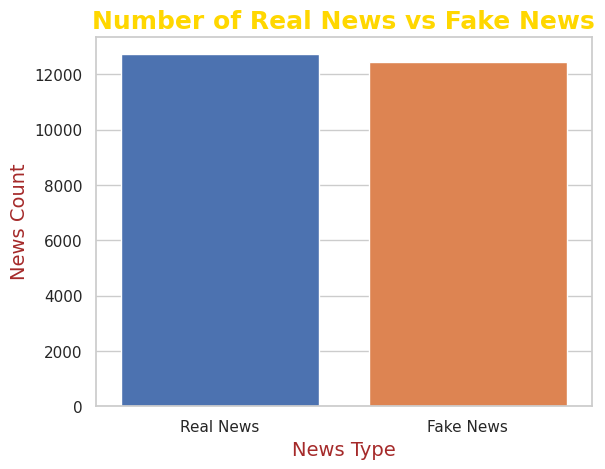

In [26]:
sns.set_theme(style = "whitegrid")

x_axis = ["Real News", "Fake News"]
y_axis = [real_news_dataset1.shape[0], fake_news_dataset1.shape[0]]

ax = sns.barplot(x = x_axis, y = y_axis, hue = x_axis, saturation = 1)

ax.set_title("Number of Real News vs Fake News", color = "gold", size = 18, fontweight = "bold")

ax.set_ylabel("News Count", color = "brown", size = 14)
ax.set_xlabel("News Type", color = "brown", size = 14);

As expected from a dataset made for machine learning, the number of real and the number of fake news is roughly the same. Now we will take a look at the lengths of each article:

In [27]:
real_news_dataset1["text"].str.len().describe()

count     12721.000000
mean       5727.838613
std        4740.384634
min           3.000000
25%        2796.000000
50%        5162.000000
75%        7347.000000
max      107014.000000
Name: text, dtype: float64

In [28]:
real_news_dataset1["text"].str.len().median()

5162.0

In [29]:
fake_news_dataset1["text"].str.len().describe()

count     12446.000000
mean       3655.224168
std        5287.834152
min           2.000000
25%        1222.250000
50%        2344.500000
75%        4168.750000
max      142961.000000
Name: text, dtype: float64

In [30]:
fake_news_dataset1["text"].str.len().median()

2344.5

As we can see just from the numbers themselves, the fake news are generally much shorter than their real counterparts. Let's visualize this with a plot. We will take a look at the count of the articles with length above 25000 words and if its small enough, we will not display them on the plot.

In [31]:
print("Real news with length above 25000: " + str(real_news_dataset1[real_news_dataset1["text"].str.len() > 25000].shape[0]))
print("Fake news with length above 25000: " + str(fake_news_dataset1[fake_news_dataset1["text"].str.len() > 25000].shape[0]))

Real news with length above 25000: 124
Fake news with length above 25000: 114


These numbers are really small, compared to more than 25000 articles so it's safe to just not display them.

In [32]:
def plot_word_count_histogram(datasets, column, xlim):
    plt.figure(figsize = (10, 6))

    if column == "text":
        label_real = "Real News Word Count"
        label_fake = "Fake News Word Count"
        plt.title("Text Length Comparison between Real and Fake News", fontsize = 20)


    elif column == "title":
        label_real = "Real News Title Word Count"
        label_fake = "Fake News Title Word Count"
        plt.title("Comparison of Text Length in Titles between Real and Fake News", fontsize = 20)


    sns.histplot(x = datasets[0][column].str.len(), color = "blue", label = label_real, element = "step", stat = "count", alpha = 0.5)
    sns.histplot(x = datasets[1][column].str.len(), color = "orange", label = label_fake, element = "step", stat = "count", alpha = 0.7)

    plt.legend()

    plt.xlabel("Text Length", color = "brown", size = 14)
    plt.ylabel("Article Counts", color = "brown", size = 14);

    plt.xlim((0, xlim));

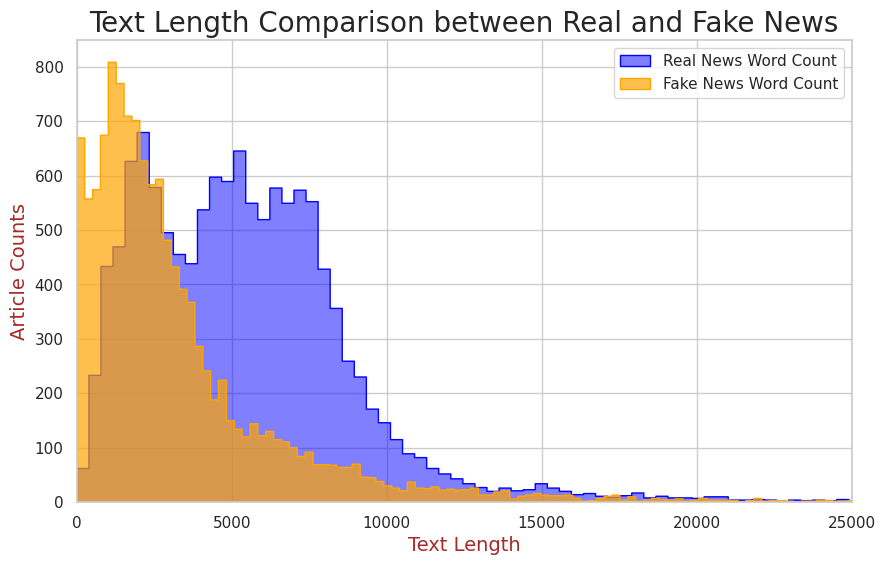

In [33]:
datasets1 = [real_news_dataset1, fake_news_dataset1]
plot_word_count_histogram(datasets1, "text", 25000)

Like we expected, the plot confirmed our observation.

Now it's time to explore the most used words in both the real and the fake news. We will first prepare our stopwords and our stemmer. We will add "u" to our stop words, because it showed up further in the exploration and it doesn't give away any information.

In [34]:
nltk.download("stopwords")
stop_words_english = set(stopwords.words("english"))
stop_words_spanish = set(stopwords.words("spanish"))
stop_words = set([word for word in stop_words_english] + [word for word in stop_words_spanish] + ["u"])

[nltk_data] Downloading package stopwords to /home/gecata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
stemmer = PorterStemmer()

Now we are ready to define a function, which creates a word counter for a given dataset and column ("text" and "title").

In [36]:
def create_counter_by_column(dataset, column):
    concatenated_text = dataset[column].str.cat(sep = " ")

    word_counter_raw = Counter(re.split(r"\W+", concatenated_text.lower()))
    word_counter_with_stopwords = Counter({word: count for word, count in word_counter_raw.items() if word not in stop_words})

    word_counter = Counter()

    for word in word_counter_with_stopwords:
        stemmed = stemmer.stem(word)
        try:
            word_counter[stemmed] += word_counter_with_stopwords[stemmed]
        except(KeyError):
            word_counter[stemmed] = 0
            word_counter[stemmed] += word_counter_with_stopwords[stemmed]

    return word_counter

Now we can create the counters for the real and the fake news and plot bar charts with the top 20 most used words.

In [37]:
def plot_bar_chart_for_most_common_20(dataset, column, label):
    words = []
    word_counts = []

    plt.figure(figsize = (24, 8))

    plt.title(f"Top 20 words in {label}", size = 20)


    for word, count in create_counter_by_column(dataset, column).most_common(20):
        words.append(word)
        word_counts.append(count)


    ax = sns.barplot(x = words, y = word_counts, hue = words)
    ax.set_xlabel("20 Most common words", color = "brown", size = 16)
    ax.set_ylabel("Times used", color = "brown", size = 16)

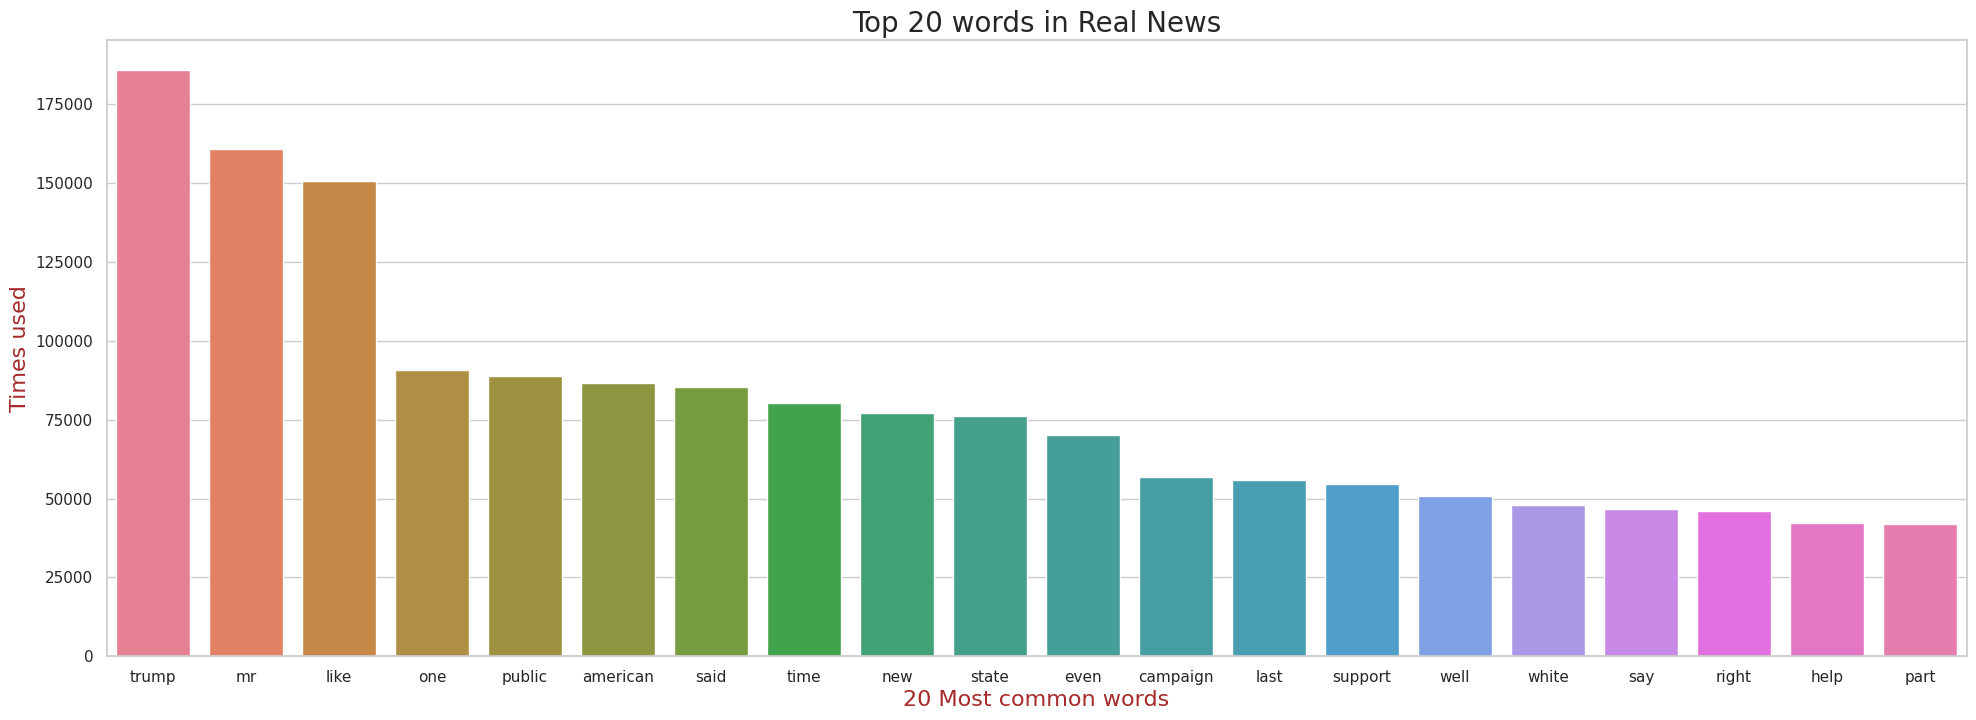

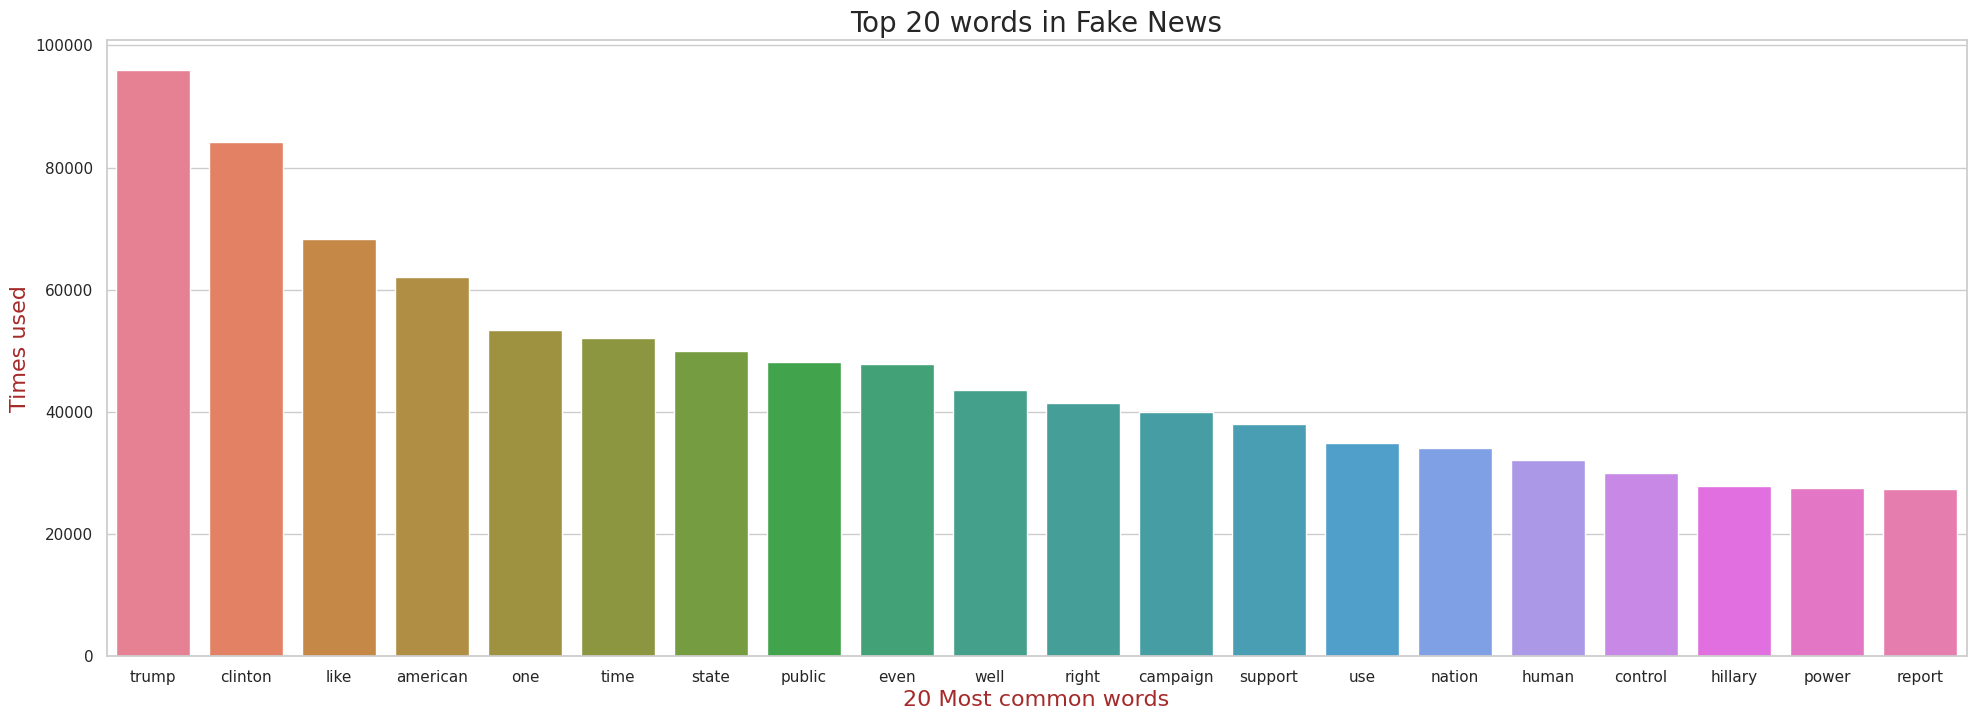

In [38]:
plot_bar_chart_for_most_common_20(real_news_dataset1, "text", "Real News")
plot_bar_chart_for_most_common_20(fake_news_dataset1, "text", "Fake News")

Another interesting way to visualize the word counts is by creating word clouds. This is an image representation of the most common words for a given text, where the more used a word is, the bigger it's displayed. It's a visually appealing way to provide an intuition on the most common topics of a certain text. Let's create these word clouds.

In [39]:
real_news_dataset1_word_counter_text = create_counter_by_column(real_news_dataset1, "text")
fake_news_dataset1_word_counter_text = create_counter_by_column(fake_news_dataset1, "text")

In [40]:
def create_word_cloud(word_counter, label):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

    plt.figure(figsize=(10, 5))
    plt.title(f"Word Cloud for {label}", size = 22, color = "brown")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.show()

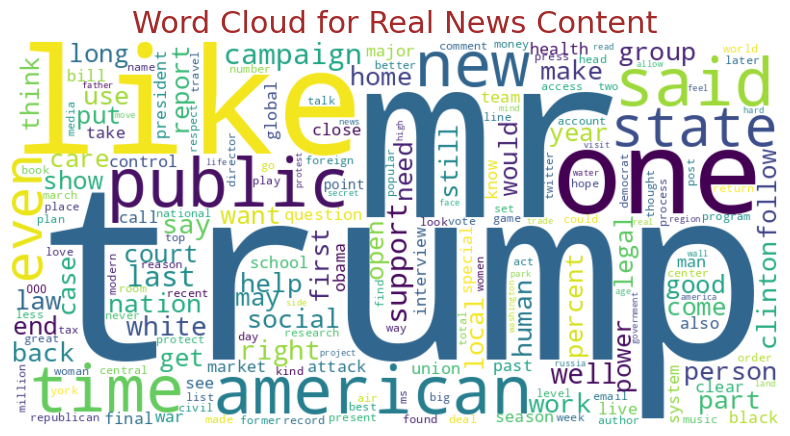

In [41]:
create_word_cloud(real_news_dataset1_word_counter_text, "Real News Content")

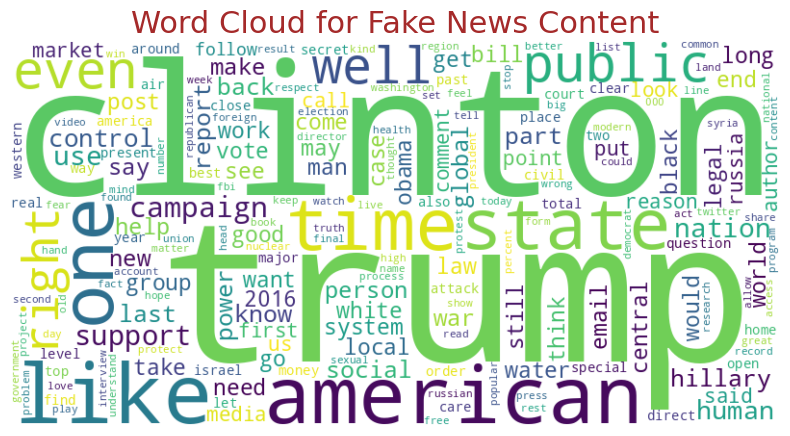

In [42]:
create_word_cloud(fake_news_dataset1_word_counter_text, "Fake News Content")

Here we can't see any clear patterns to distinguish between real and fake news. It's apparent, that at least in this dataset, the most common topic is politics. The most common words are really similar with one big exception. "Clinton" takes the second place in the most common words in the fake news, while in the real ones, she isn't even in the top 20. Let's explore this.

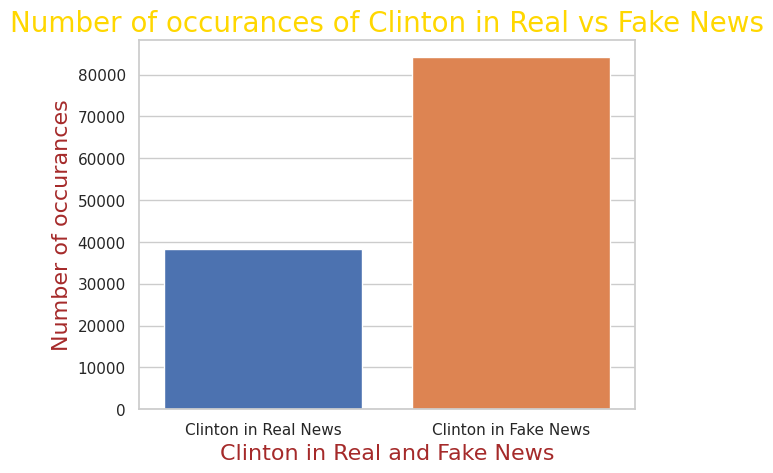

In [43]:
x_axis = ["Clinton in Real News", "Clinton in Fake News"]
y_axis = [real_news_dataset1_word_counter_text["clinton"], fake_news_dataset1_word_counter_text["clinton"]]

ax = sns.barplot(x = x_axis, y = y_axis, hue = x_axis, saturation = 1)

ax.set_xlabel("Clinton in Real and Fake News", size = 16, color = "brown")
ax.set_ylabel("Number of occurances", size = 16, color = "brown")
ax.set_title("Number of occurances of Clinton in Real vs Fake News", size = 20, color = "gold");

That's a really interesting observation, but it might be dataset-specific. We can't say anything for sure before we take a look at the second dataset. Now to see if there are any common word combinations, we will create bi-grams for the news contents and titles.

Bi-gram computation takes a lot of time and memory. For this reason, I used the commented code to generate them and save them in a file, which I can then load quickly.

In [44]:
def make_ngrams(dataset, n):
    concatenated = dataset.str.cat(sep = " ")
    punctuation = set(string.punctuation + "'" + '"' + "“" + "’" + "”")

    tokens = [word for word in word_tokenize(concatenated.lower()) if word not in stop_words and word not in punctuation]

    n_grams = list(ngrams(tokens, n))

    ngram_counts = Counter(n_grams)

    return ngram_counts

In [45]:
# real_news_dataset1_bi_gram = make_ngrams(real_news_dataset1["text"], 2)
# fake_news_dataset1_bi_gram = make_ngrams(fake_news_dataset1["text"], 2)

In [46]:
# with open("/content/drive/MyDrive/Data_science_final_project/saved_data/real_news_dataset1_bi_gram.pkl", "wb") as file:
#     pickle.dump(real_news_dataset1_bi_gram, file)

# with open("/content/drive/MyDrive/Data_science_final_project/saved_data/fake_news_dataset1_bi_gram.pkl", "wb") as file:
#     pickle.dump(fake_news_dataset1_bi_gram, file)

In [47]:
with open("saved_data/real_news_dataset1_bigram.pkl", "rb") as file:
    real_news_dataset1_bi_gram = pickle.load(file)

with open("saved_data/fake_news_dataset1_bigram.pkl", "rb") as file:
    fake_news_dataset1_bi_gram = pickle.load(file)

Let's plot the most common combinations of 2 words with the same function we used to plot the most common words.

In [48]:
def plot_bar_chart_for_ngram_most_common_20(ngram, label):
    combinations = []
    combination_counts = []

    plt.figure(figsize = (24, 6))

    plt.title(f"Top 20 combinations of {label}", size = 20, color = "forestgreen")


    for combination, count in ngram.most_common(20):
        combinations.append(combination)
        combination_counts.append(count)

    combinations = [" ".join(comb) for comb in combinations]

    ax = sns.barplot(x = combinations, y = combination_counts, hue = combinations)

    ax.set_xlabel("20 Most common words", color = "brown", size = 16)
    plt.xticks(rotation = 25)
    ax.set_ylabel("Times used", color = "brown", size = 16)

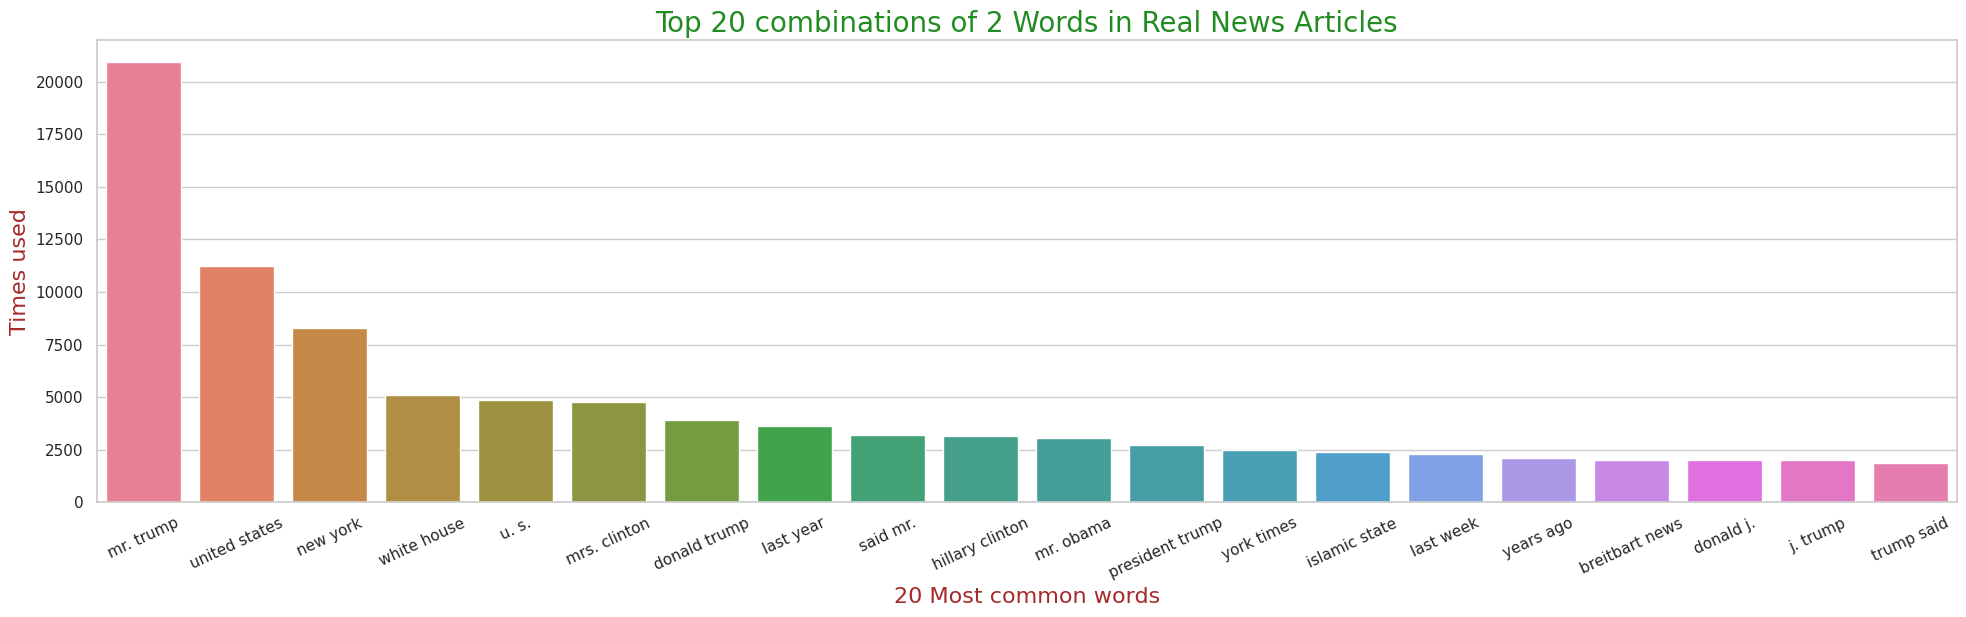

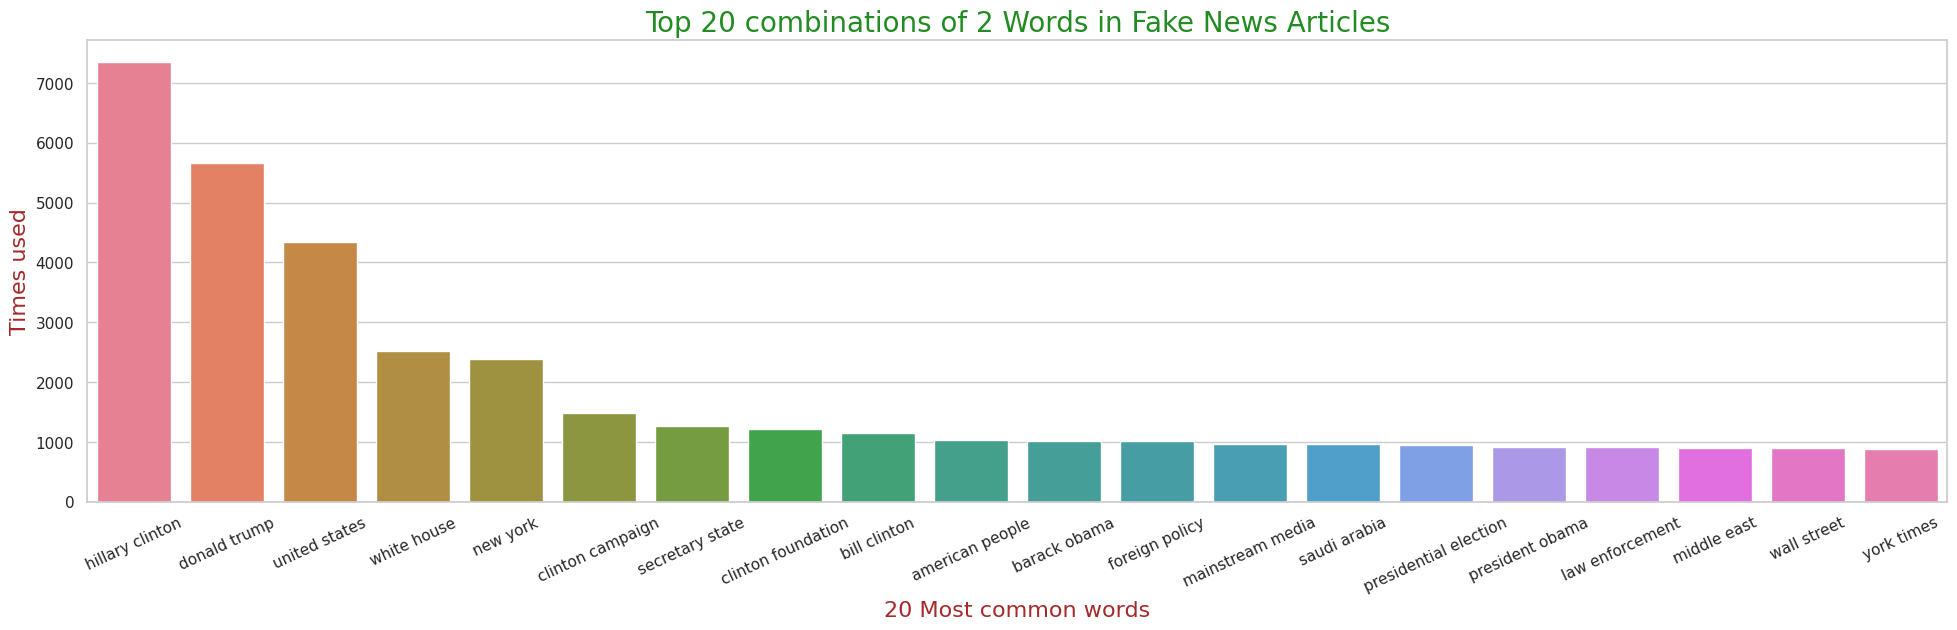

In [49]:
plot_bar_chart_for_ngram_most_common_20(real_news_dataset1_bi_gram, "2 Words in Real News Articles")
plot_bar_chart_for_ngram_most_common_20(fake_news_dataset1_bi_gram, "2 Words in Fake News Articles")

Again, we can see no clear pattern to distinguish between real and fake news with the same exception for Hilary Clinton.

Now lets do the same analysis and visualization for the article titles to see if they would be different:

We will again begin with the word counts:

In [50]:
real_news_dataset1["title"].str.len().describe()

count    12721.000000
mean        79.016665
std         16.884561
min          1.000000
25%         69.000000
50%         80.000000
75%         89.000000
max        269.000000
Name: title, dtype: float64

In [51]:
real_news_dataset1["title"].str.len().median()

80.0

In [52]:
fake_news_dataset1["title"].str.len().describe()

count    12446.000000
mean        69.240559
std         26.835334
min          3.000000
25%         52.000000
50%         68.000000
75%         84.000000
max        456.000000
Name: title, dtype: float64

In [53]:
fake_news_dataset1["title"].str.len().median()

68.0

It doesn't look like there would be as big of a difference, as with the text length. Let's see the plot:

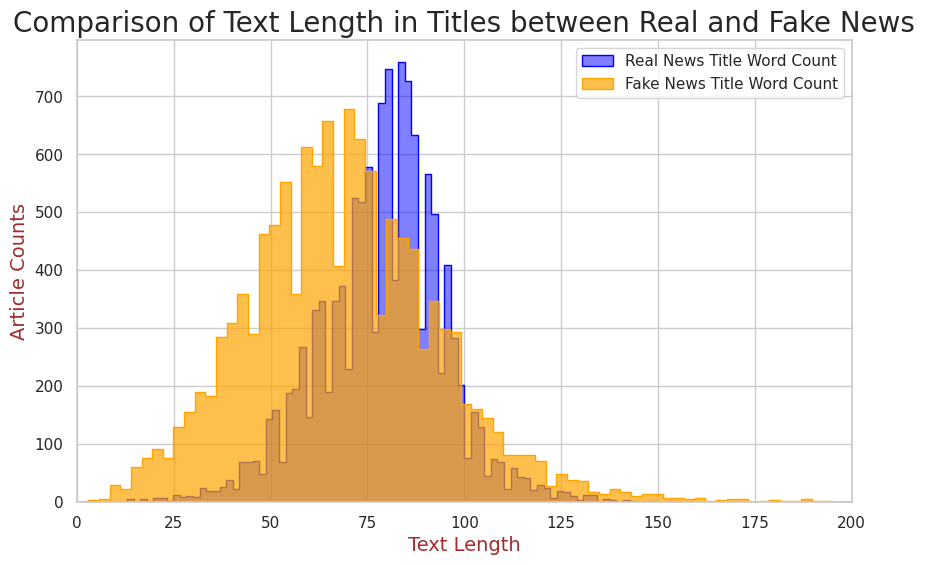

In [54]:
plot_word_count_histogram(datasets1, "title", 200)

As we can see, fake news titles are also generally shorter, but the difference is not that significant. Now lets explore the most common words:

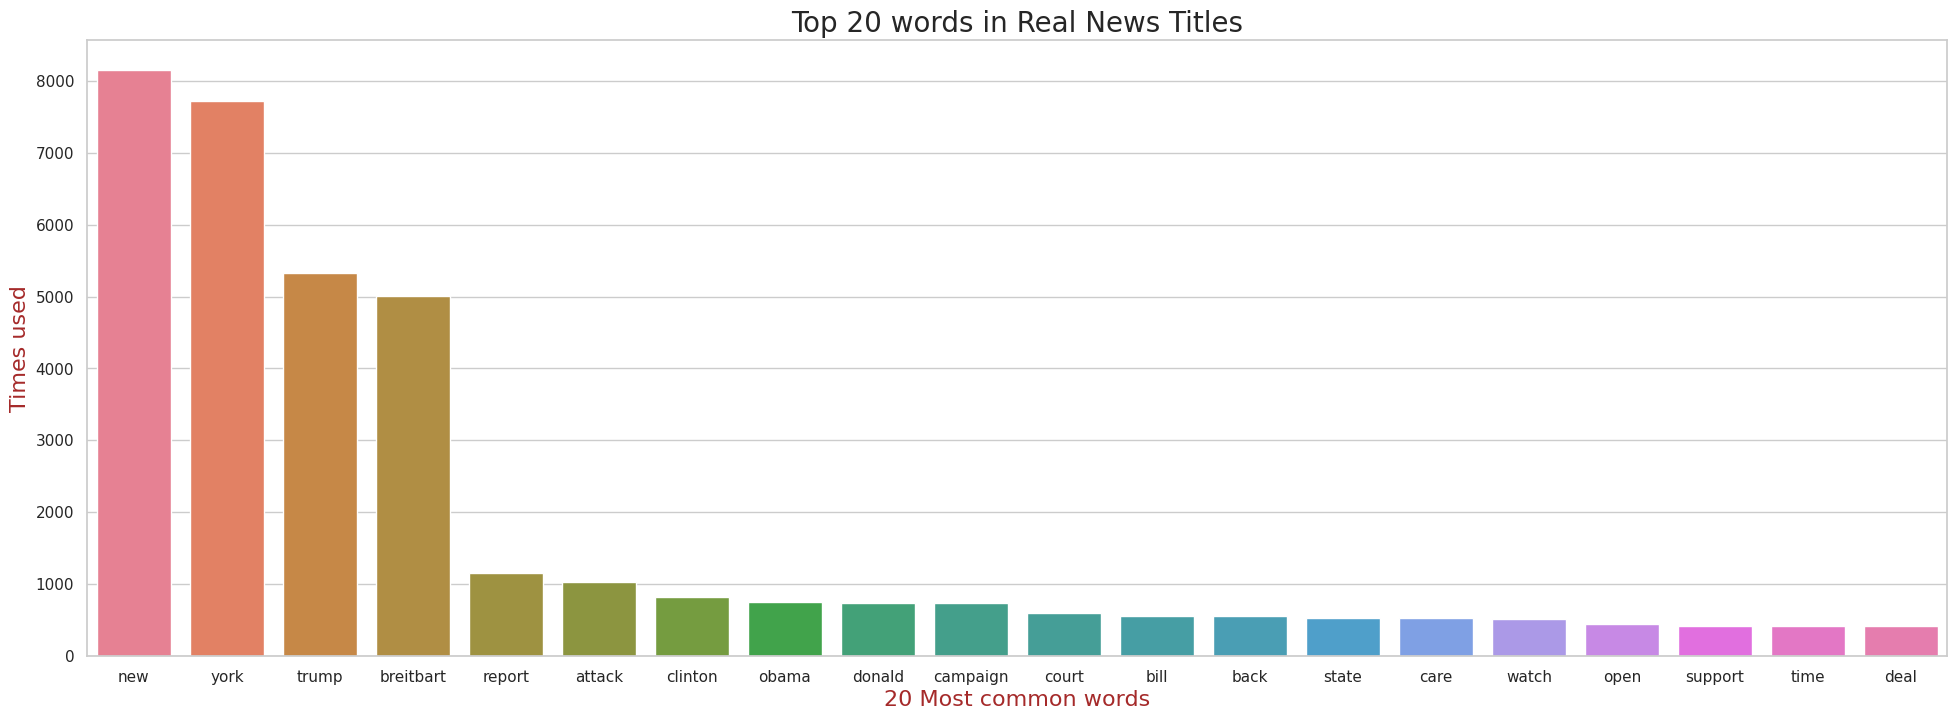

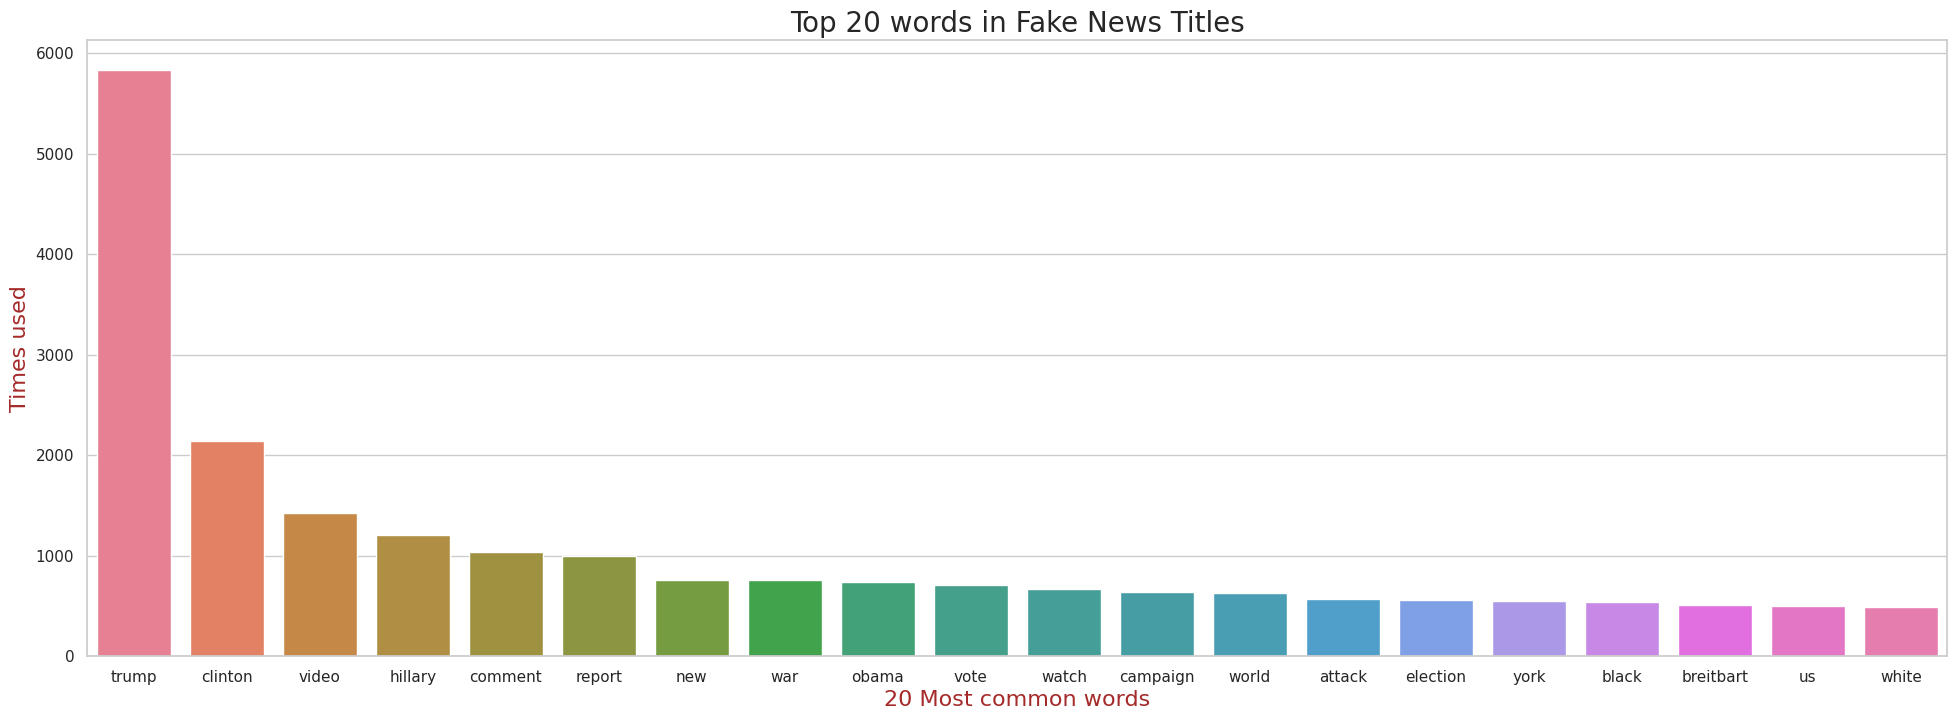

In [55]:
plot_bar_chart_for_most_common_20(real_news_dataset1, "title", "Real News Titles")
plot_bar_chart_for_most_common_20(fake_news_dataset1, "title", "Fake News Titles")

We can see similar trends, with the exception, that New York appears a lot in the titles of real news. Thats interesting... Now let's see the word clouds:

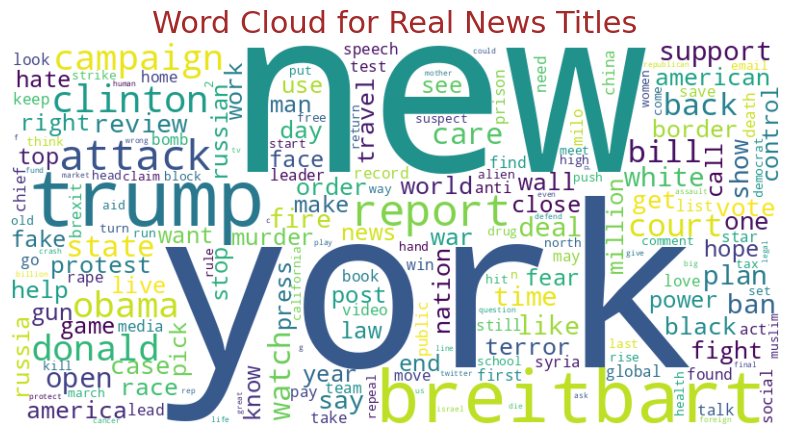

In [56]:
create_word_cloud(create_counter_by_column(real_news_dataset1, "title"), "Real News Titles")

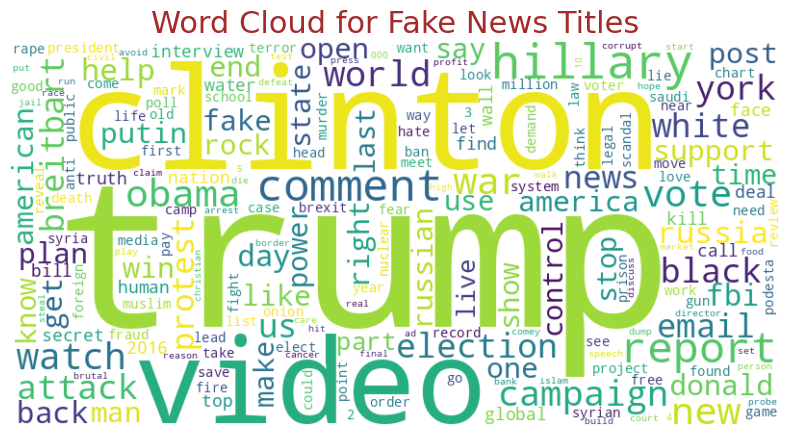

In [57]:
create_word_cloud(create_counter_by_column(fake_news_dataset1, "title"), "Fake News Titles")

Here we can see something interesting. The words "new", "york" and "breitbart" appear quite a lot in the titles of real news and not so much in the titles of the fake news. "new" and "york" may appear, because many of the real articles in this dataset could be from "New York Times". This is something, that the bi-gram analysis will prove or disprove. The more interesting observation is that "Breitbart", a not so reputable news source, appears a lot more in the titles of the real news.

Now lets do a bi-gram analysis for the titles. They are much shorter so we don't have to load pre-computed bi-grams.

In [58]:
real_news_dataset1_title_bi_gram = make_ngrams(real_news_dataset1["title"], 2)
fake_news_dataset1_title_bi_gram = make_ngrams(fake_news_dataset1["title"], 2)

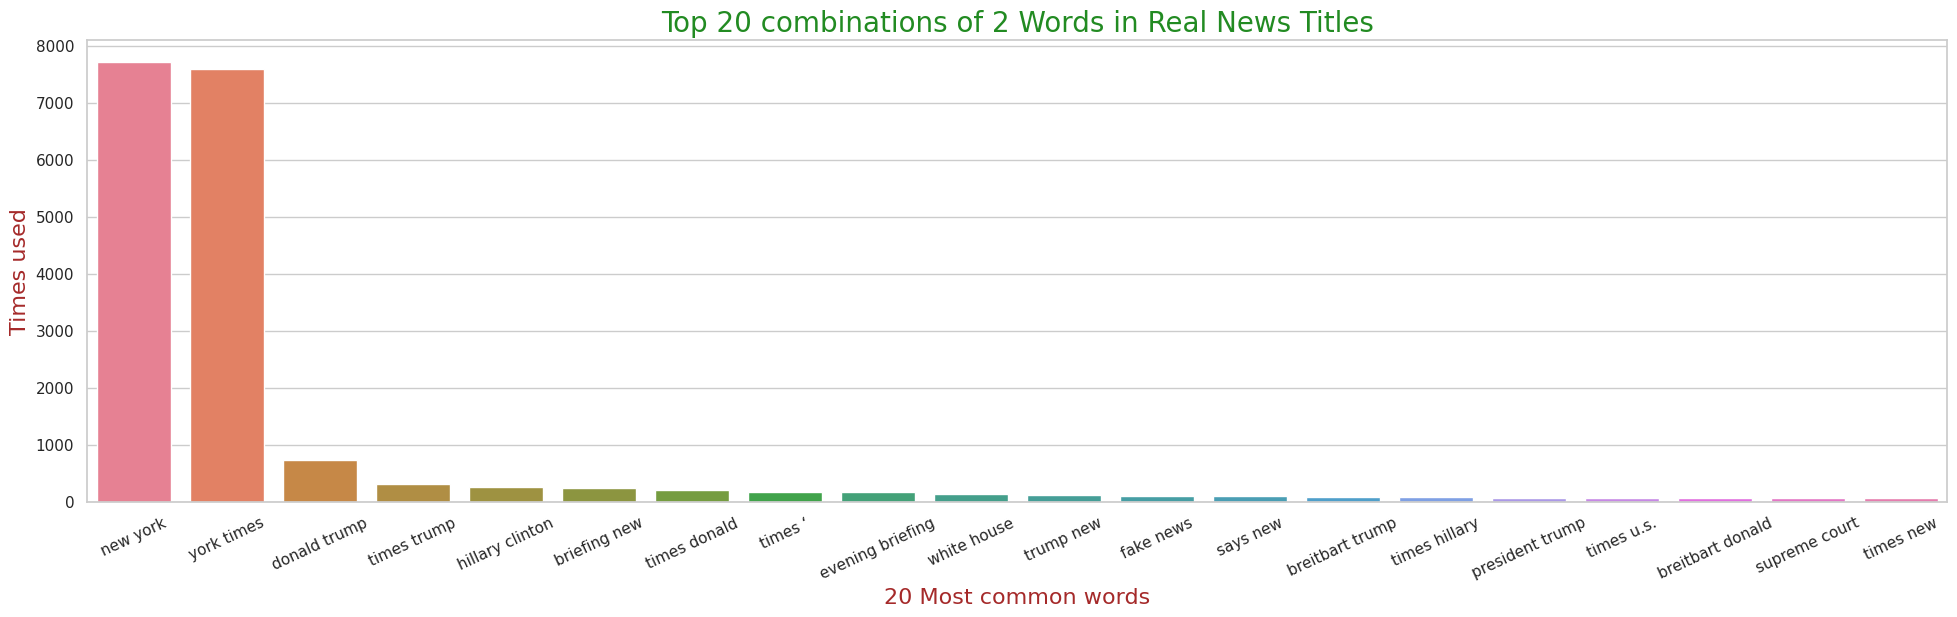

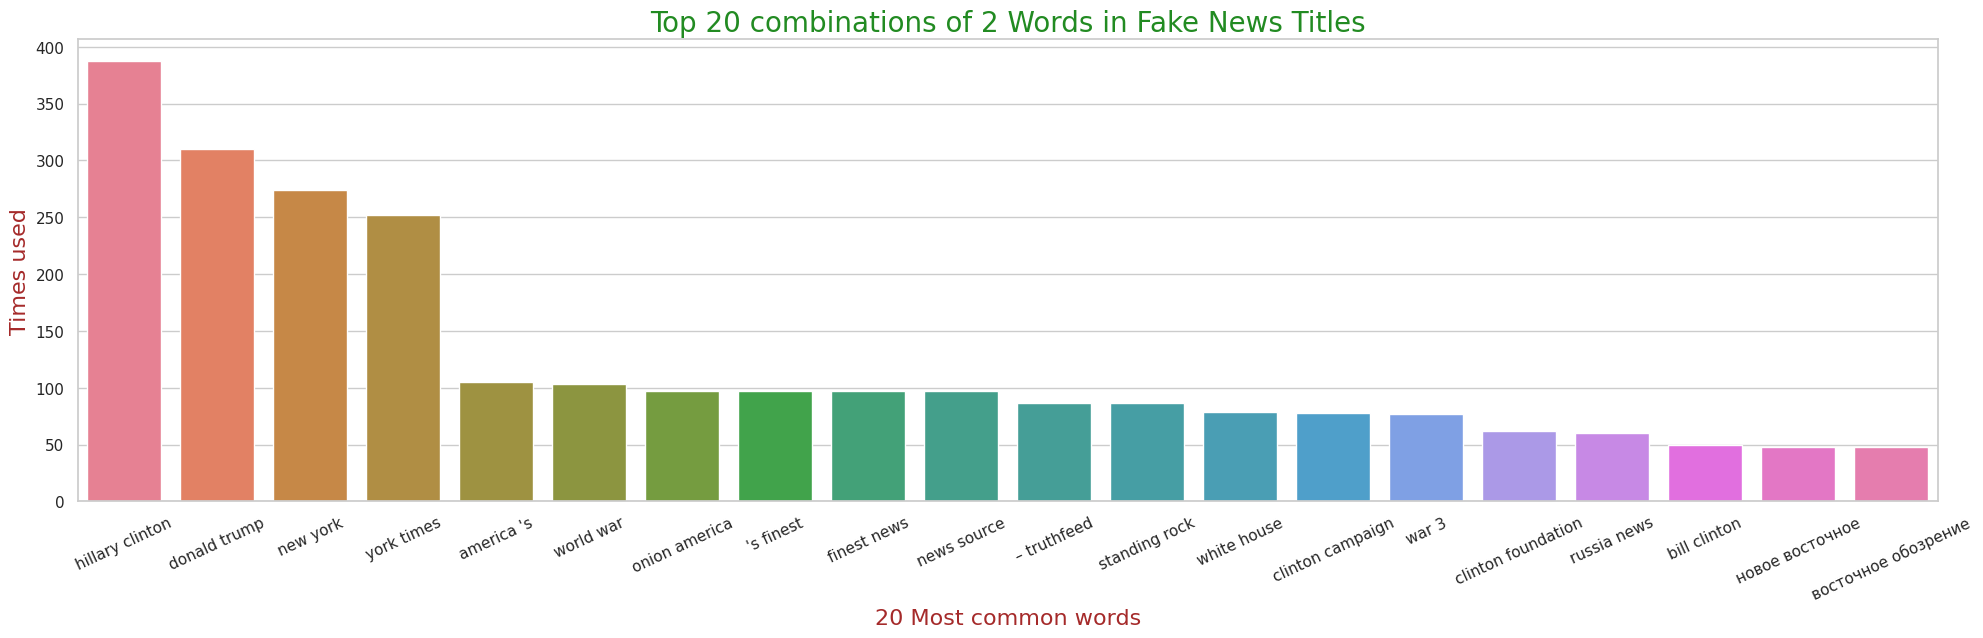

In [59]:
plot_bar_chart_for_ngram_most_common_20(real_news_dataset1_title_bi_gram, "2 Words in Real News Titles")
plot_bar_chart_for_ngram_most_common_20(fake_news_dataset1_title_bi_gram, "2 Words in Fake News Titles")

This confirmed our observation about "New York Times". We can also see a tendency for the fake news to talk more about war and Russia.

Now we can explore the truthfulness of the authors. We will see how trustworthy each author is by calculating their real to fake news ratio:

In [60]:
def calculate_author_trustworthiness():
    ratios = {}

    for author in labeled_news_dataset1[(labeled_news_dataset1["author"].notna()) & (labeled_news_dataset1["author"] != "Unknown")]["author"].unique():
        all_articles = len(labeled_news_dataset1[labeled_news_dataset1["author"] == author])
        fake_articles = len(labeled_news_dataset1[(labeled_news_dataset1["author"] == author) & (labeled_news_dataset1["label"] == 1)])

        ratios[author] = fake_articles / all_articles

    return ratios

In [61]:
ratios = calculate_author_trustworthiness()

In [62]:
authors_only_real_news_count = sum(1 for _, num in ratios.items() if num == 1)
authors_only_fake_news_count = sum(1 for _, num in ratios.items() if num == 0)
authors_mixed_count = sum(1 for _, num in ratios.items() if num != 1 and num != 0)

In [63]:
print("Number of authors with only real news: " + str(authors_only_real_news_count))
print("Number of authors with only fake news: " + str(authors_only_fake_news_count))
print("Number of authors with real and fake news: " + str(authors_mixed_count))

Number of authors with only real news: 1482
Number of authors with only fake news: 2469
Number of authors with real and fake news: 464


Lets plot this with a bar chart:

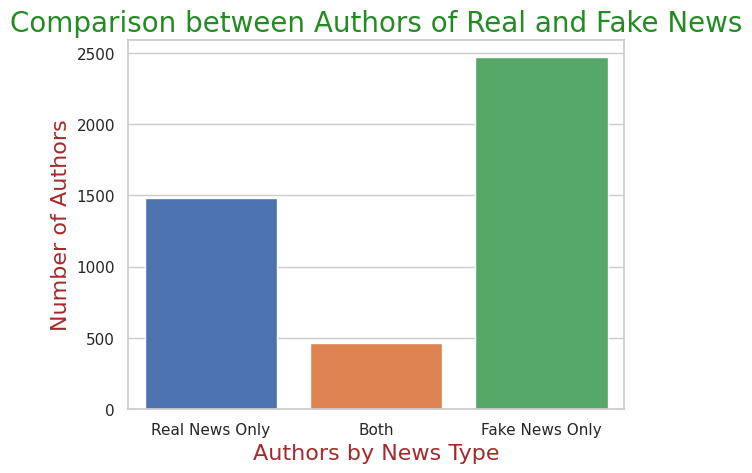

In [64]:
x_axis = ["Real News Only", "Both", "Fake News Only"]
y_axis = [authors_only_real_news_count, authors_mixed_count, authors_only_fake_news_count]

ax = sns.barplot(x = x_axis, y = y_axis, hue = x_axis, saturation = 1)

ax.set_xlabel("Authors by News Type", size = 16, color = "brown")
ax.set_ylabel("Number of Authors", size = 16, color = "brown")

ax.set_title("Comparison between Authors of Real and Fake News", size = 20, color = "forestgreen");

As we can see, most authors prefer to write only real or only fake articles. That can be explained, due to the fact, that authors of real news want to keep a good reputation and can't afford to publish false informaton, while authors of fake news do this to spread misinformation and have no interest in writing true information.

Now, we will do the same exploration for the second dataset. Let's begin with the lengths of each article.

In [65]:
real_news_dataset2["text"].str.len().describe()

count    21416.000000
mean      2383.389755
std       1684.796417
min        152.000000
25%        914.000000
50%       2222.000000
75%       3237.000000
max      29781.000000
Name: text, dtype: float64

In [66]:
real_news_dataset2["text"].str.len().median()

2222.0

In [67]:
fake_news_dataset2["text"].str.len().describe()

count    22761.000000
mean      2627.453759
std       2531.624439
min          2.000000
25%       1530.000000
50%       2205.000000
75%       3064.000000
max      51794.000000
Name: text, dtype: float64

In [68]:
fake_news_dataset2["text"].str.len().median()

2205.0

Here, the articles look a lot more similar in length. We can see, that in both real and fake news, 75% of them are below 3300 characters. Lets see how many of them have length below 7000 and decide if it`s worth it to show it in a plot.

In [69]:
real_news_dataset2[real_news_dataset2["text"].str.len() > 7000].shape[0]

234

In [70]:
fake_news_dataset2[fake_news_dataset2["text"].str.len() > 7000].shape[0]

771

This is not significant, compared to more than 40000, so it`s safe to not display them.

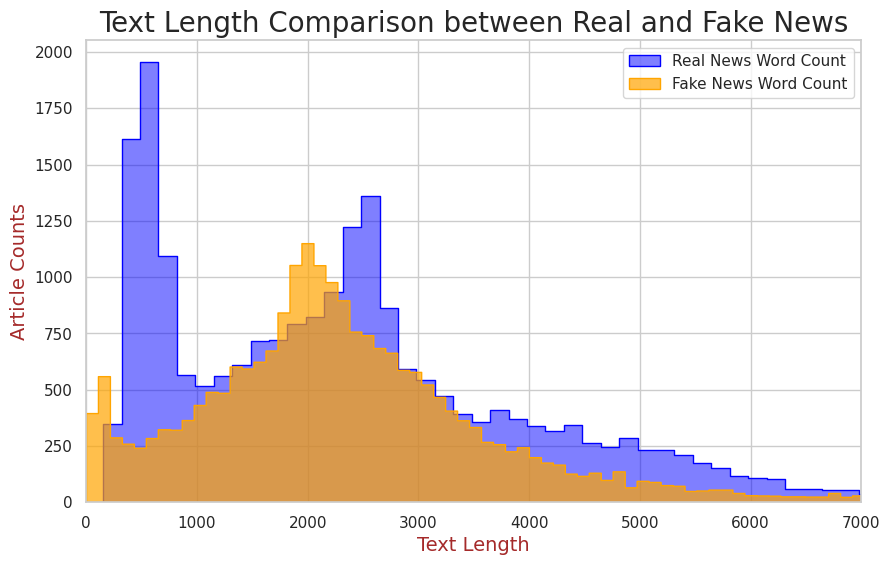

In [71]:
datasets2 = [real_news_dataset2, fake_news_dataset2]
plot_word_count_histogram(datasets2, "text", 7000)

Interesting... Here the lenghts are relatively equal and we cannot tell what is generally longer or shorter. Now let's again create a plot for the 20 most common words.

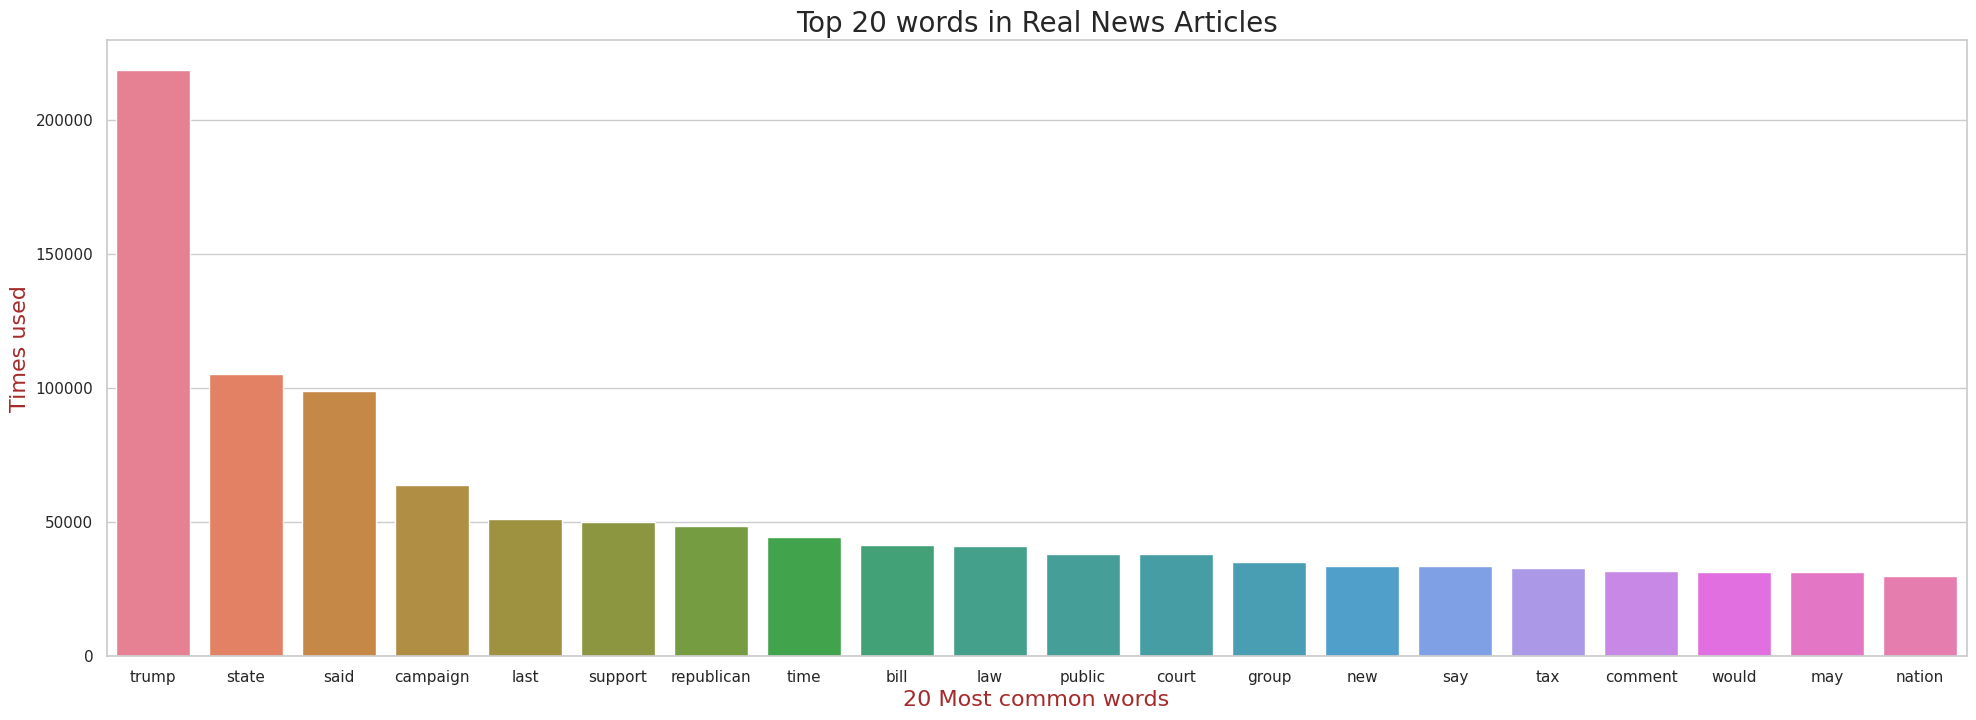

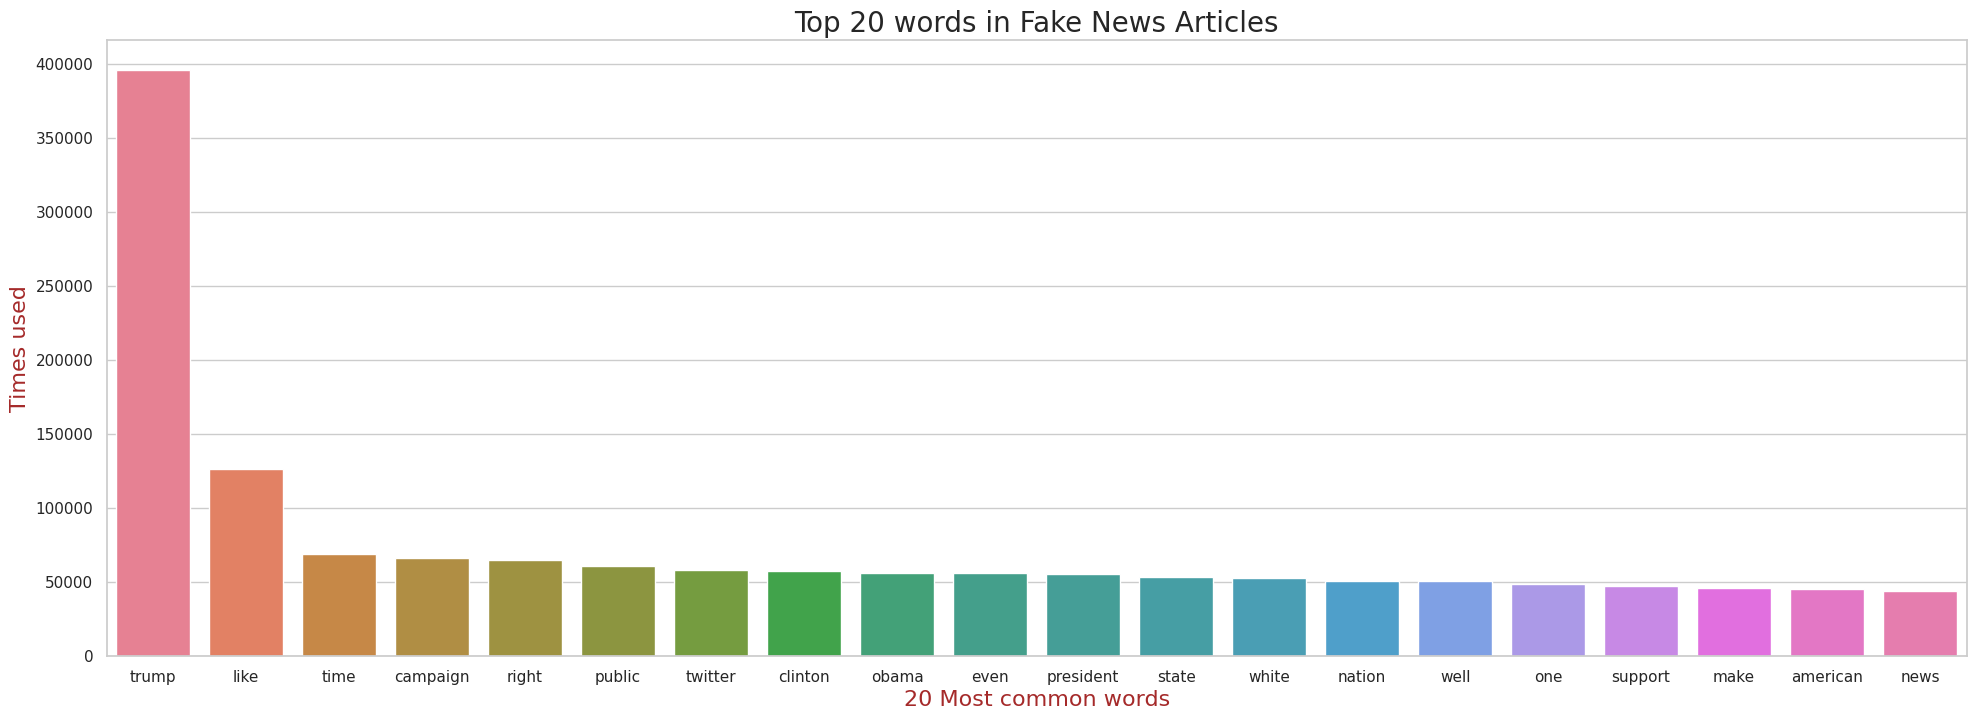

In [72]:
plot_bar_chart_for_most_common_20(real_news_dataset2, "text", "Real News Articles")
plot_bar_chart_for_most_common_20(fake_news_dataset2, "text", "Fake News Articles")

Here Donald Trump is even more popular on both ends. Now lets visualize this again with a word cloud:

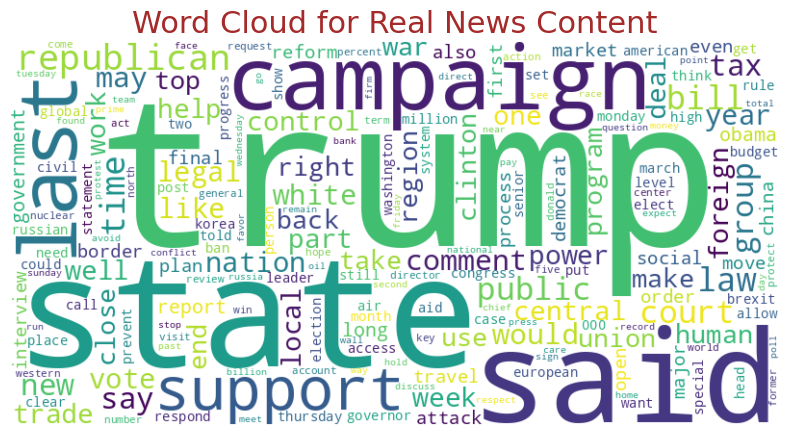

In [73]:
create_word_cloud(create_counter_by_column(real_news_dataset2, "text"), "Real News Content")

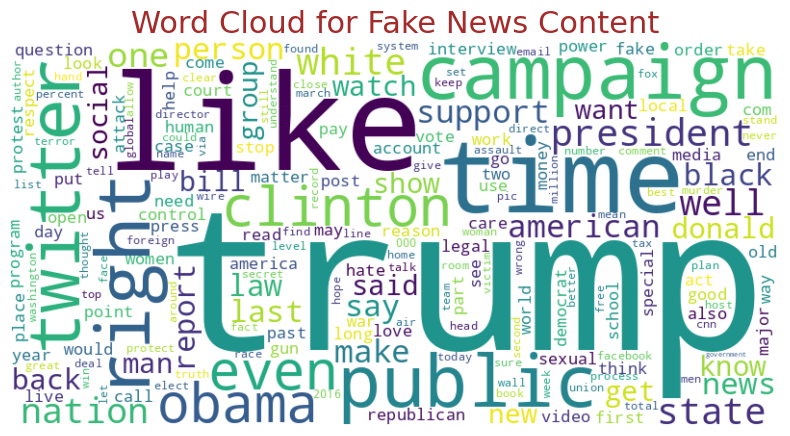

In [74]:
create_word_cloud(create_counter_by_column(fake_news_dataset2, "text"), "Fake News Content")

Again, we cannot see a clear way to tell the difference between a real and a fake article just by looking at the most popular words. The topics here are relatively the same as the first dataset.

Now lets do a bi-gram analysis for this dataset. Again, we will use a pre-computeed bi-gram.

In [75]:
# real_news_dataset2_bi_gram = make_ngrams(real_news_dataset1["text"], 2)
# fake_news_dataset2_bi_gram = make_ngrams(fake_news_dataset1["text"], 2)

In [76]:
# with open("/content/drive/MyDrive/Data_science_final_project/saved_data/real_news_dataset2_bi_gram.pkl", "wb") as file:
#     pickle.dump(real_news_dataset2_bi_gram, file)

# with open("/content/drive/MyDrive/Data_science_final_project/saved_data/fake_news_dataset2_bi_gram.pkl", "wb") as file:
#     pickle.dump(fake_news_dataset2_bi_gram, file)

In [77]:
with open("saved_data/real_news_dataset2_bigram.pkl", "rb") as file:
    real_news_dataset2_bi_gram = pickle.load(file)

with open("saved_data/fake_news_dataset2_bigram.pkl", "rb") as file:
    fake_news_dataset2_bi_gram = pickle.load(file)

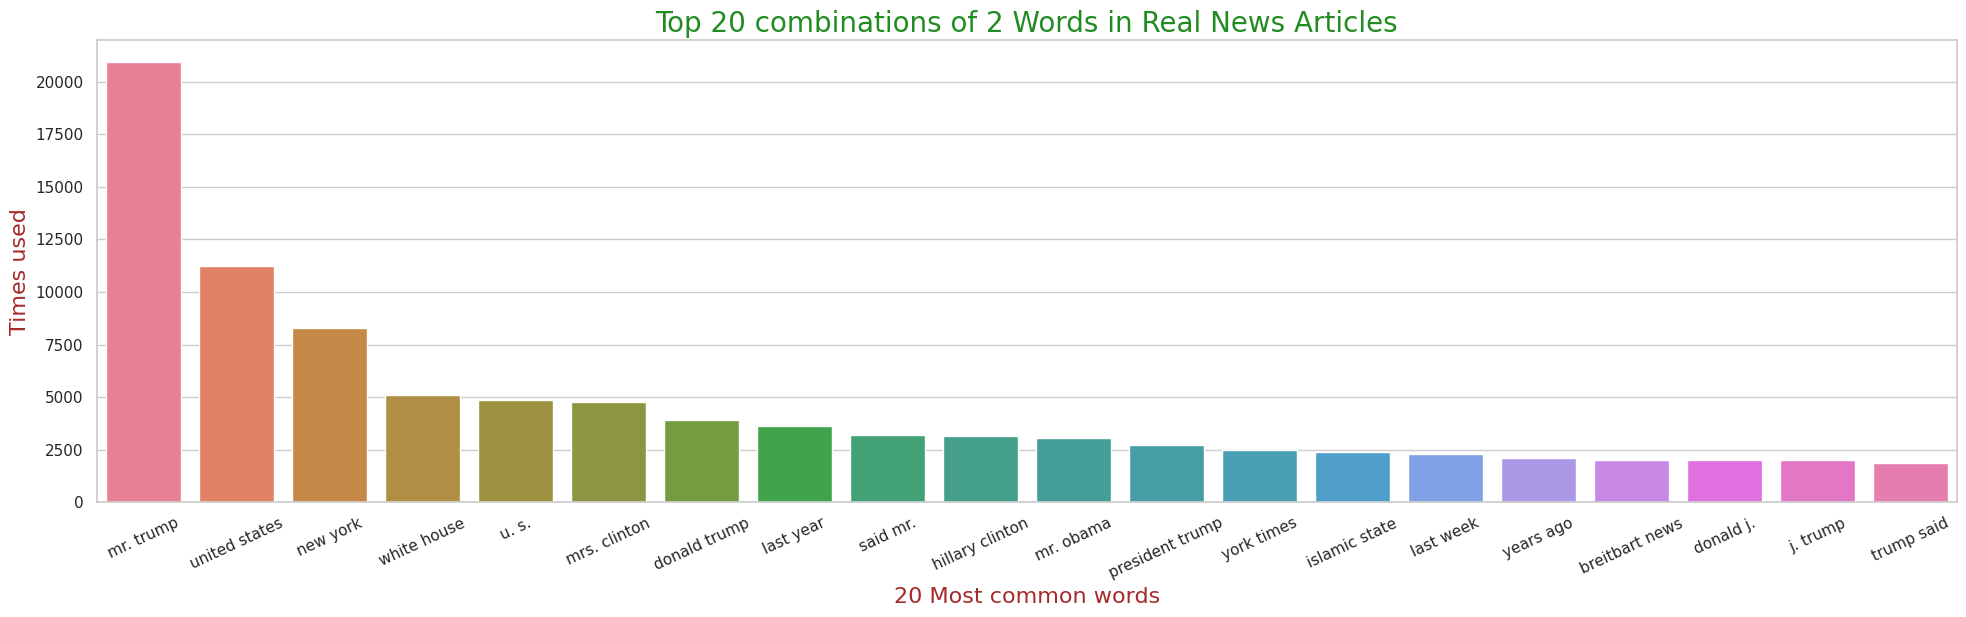

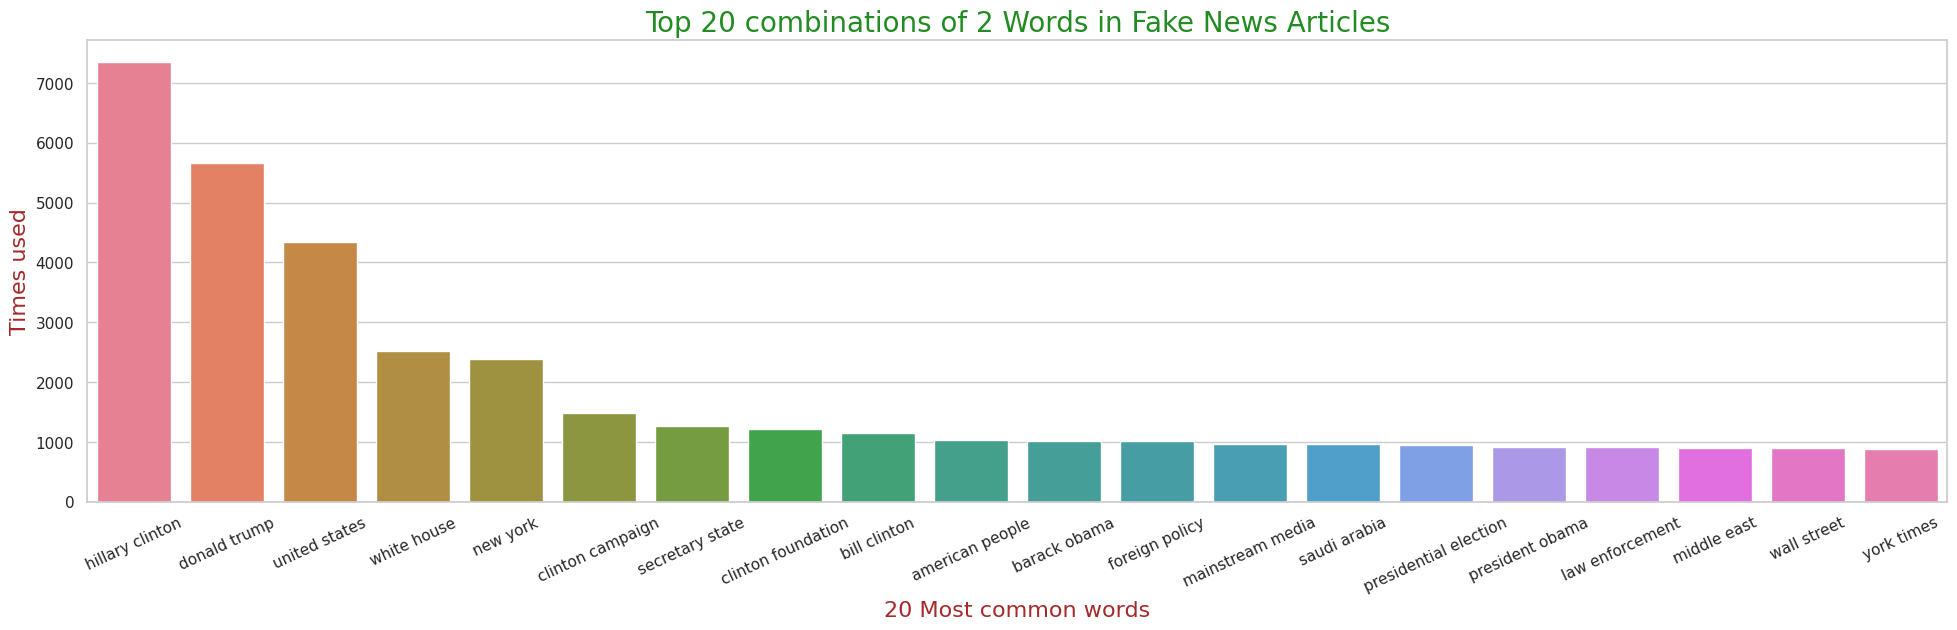

In [78]:
plot_bar_chart_for_ngram_most_common_20(real_news_dataset2_bi_gram, "2 Words in Real News Articles")
plot_bar_chart_for_ngram_most_common_20(fake_news_dataset2_bi_gram, "2 Words in Fake News Articles")

We can see again, that Clinton's name is way more popular in fake news. Let's visuaize this:

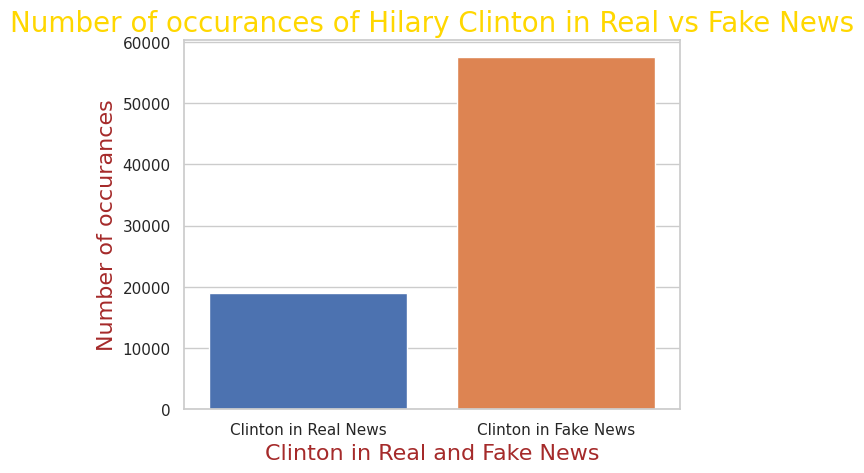

In [79]:
x_axis = ["Clinton in Real News", "Clinton in Fake News"]
y_axis = [create_counter_by_column(real_news_dataset2, "text")["clinton"], create_counter_by_column(fake_news_dataset2, "text")["clinton"]]

ax = sns.barplot(x = x_axis, y = y_axis, hue = x_axis, saturation = 1)

ax.set_xlabel("Clinton in Real and Fake News", size = 16, color = "brown")
ax.set_ylabel("Number of occurances", size = 16, color = "brown")
ax.set_title("Number of occurances of Hilary Clinton in Real vs Fake News", size = 20, color = "gold");

Again, Clinton appears a lot more in fake news. So that's not dataset-specific. An interesting observation...

We will do the same exploration for the titles of this dataset, beginning with the length.

In [80]:
real_news_dataset2["title"].str.len().describe()

count    21416.000000
mean        64.669499
std          9.166152
min         26.000000
25%         59.000000
50%         64.000000
75%         70.000000
max        133.000000
Name: title, dtype: float64

In [81]:
real_news_dataset2["title"].str.len().median()

64.0

In [82]:
fake_news_dataset2["title"].str.len().describe()

count    22761.000000
mean        94.176354
std         27.246299
min          8.000000
25%         77.000000
50%         90.000000
75%        105.000000
max        286.000000
Name: title, dtype: float64

In [83]:
fake_news_dataset2["title"].str.len().median()

90.0

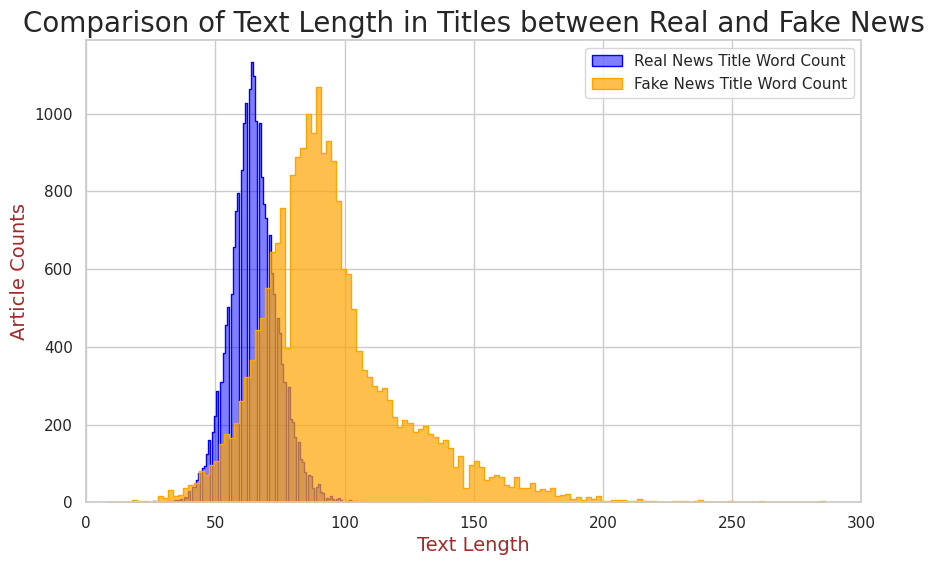

In [84]:
plot_word_count_histogram(datasets2, "title", 300)

Here we have the opposite observation. In this dataset, the fake news have longer titles. Now let's see the most common words and create word clouds for them.

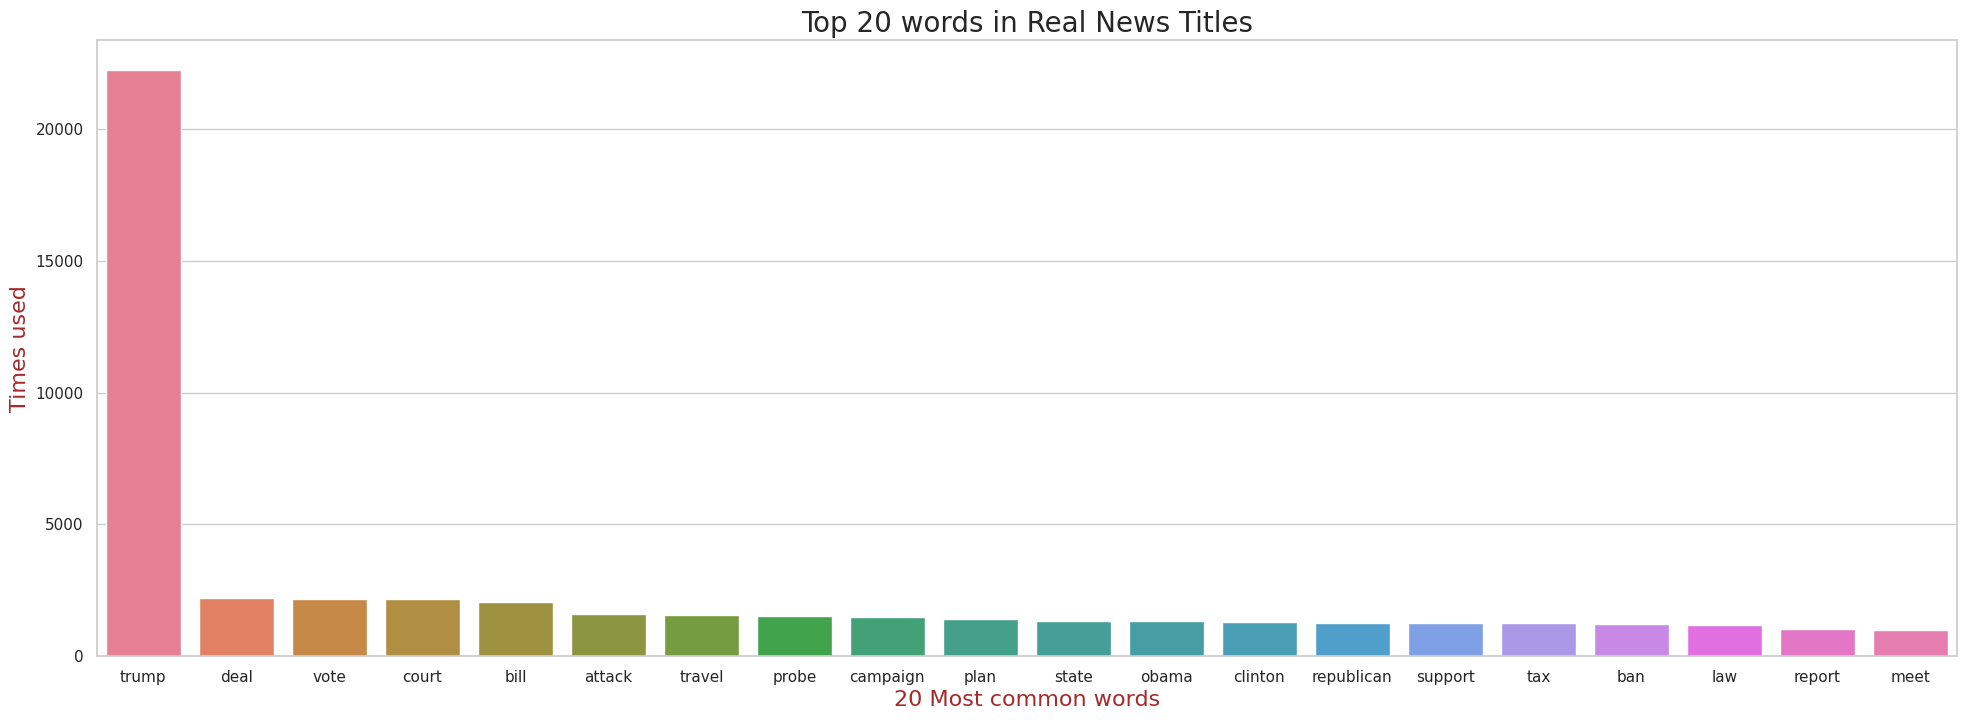

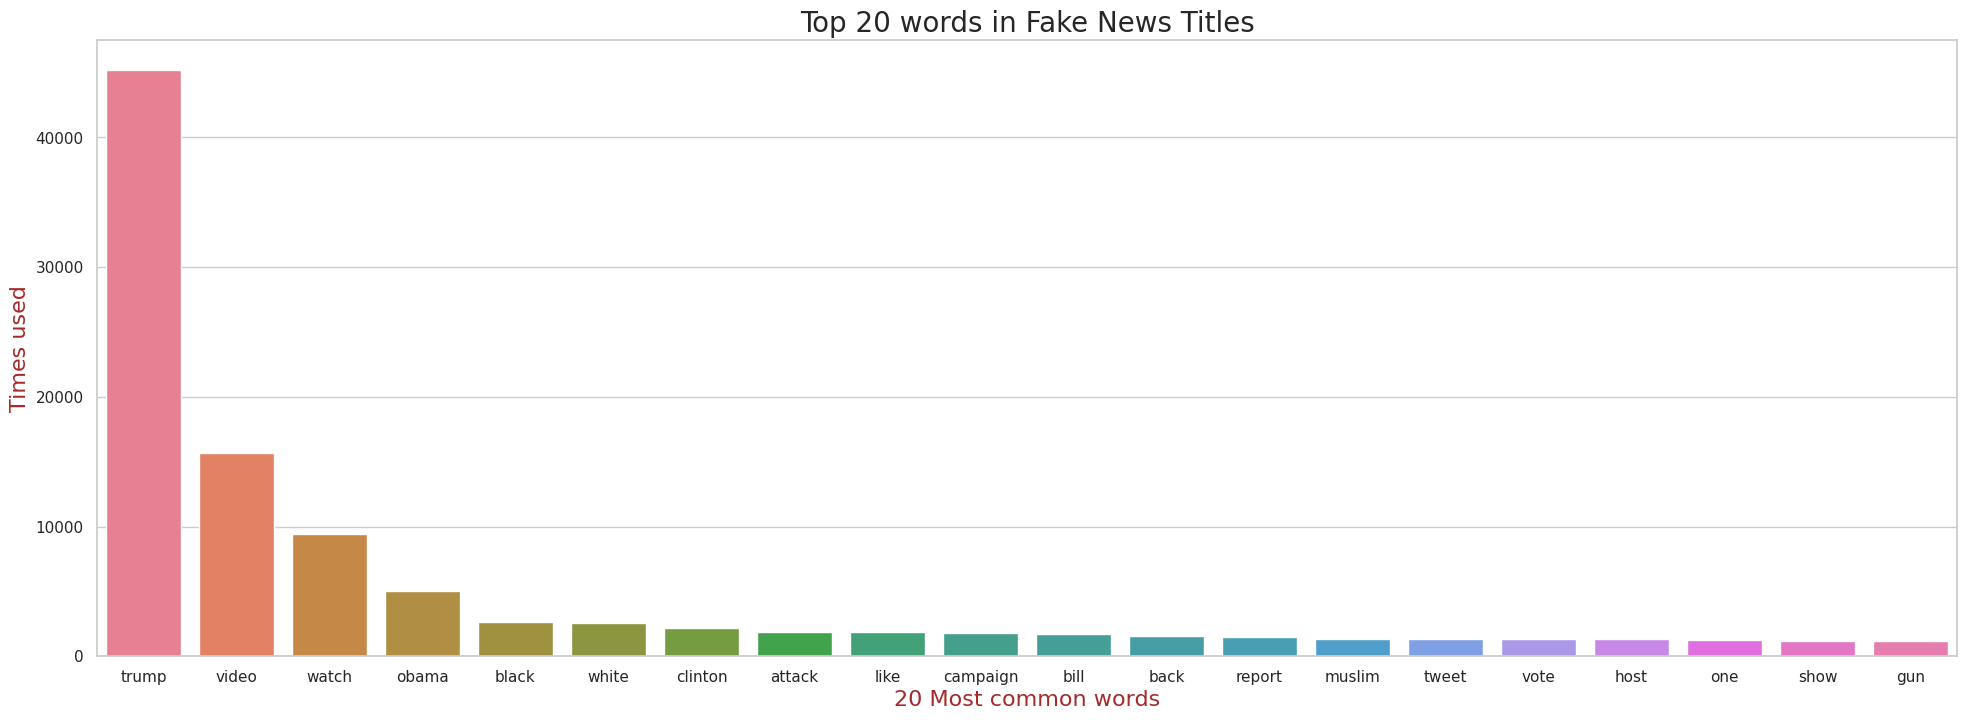

In [85]:
plot_bar_chart_for_most_common_20(real_news_dataset2, "title", "Real News Titles")
plot_bar_chart_for_most_common_20(fake_news_dataset2, "title", "Fake News Titles")

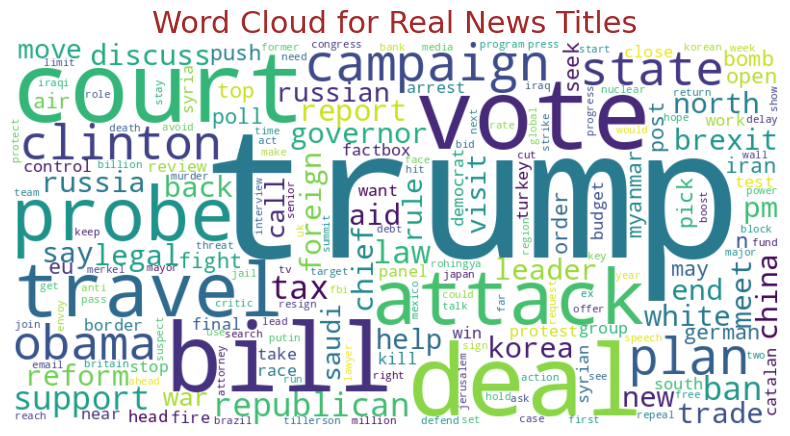

In [86]:
create_word_cloud(create_counter_by_column(real_news_dataset2, "title"), "Real News Titles")

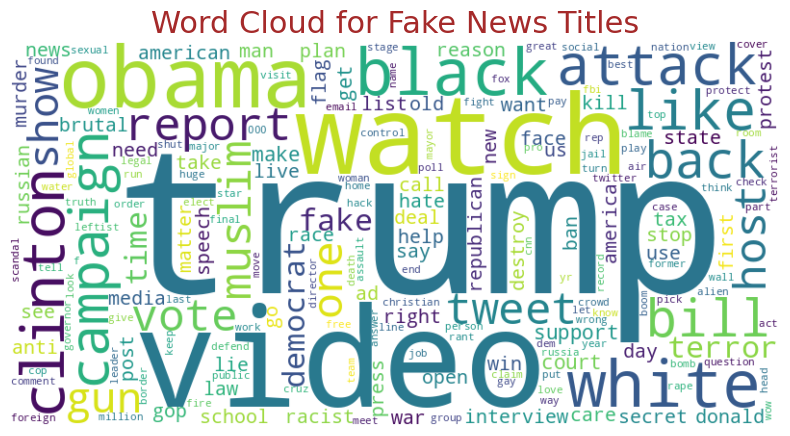

In [87]:
create_word_cloud(create_counter_by_column(fake_news_dataset2, "title"), "Fake News Titles")

By looking at the most common words alone, we can see no pattern. Let's see if the bi-gram analysis will show us something different.

In [88]:
real_news_dataset2_title_bi_gram = make_ngrams(real_news_dataset2["title"], 2)
fake_news_dataset2_title_bi_gram = make_ngrams(fake_news_dataset2["title"], 2)

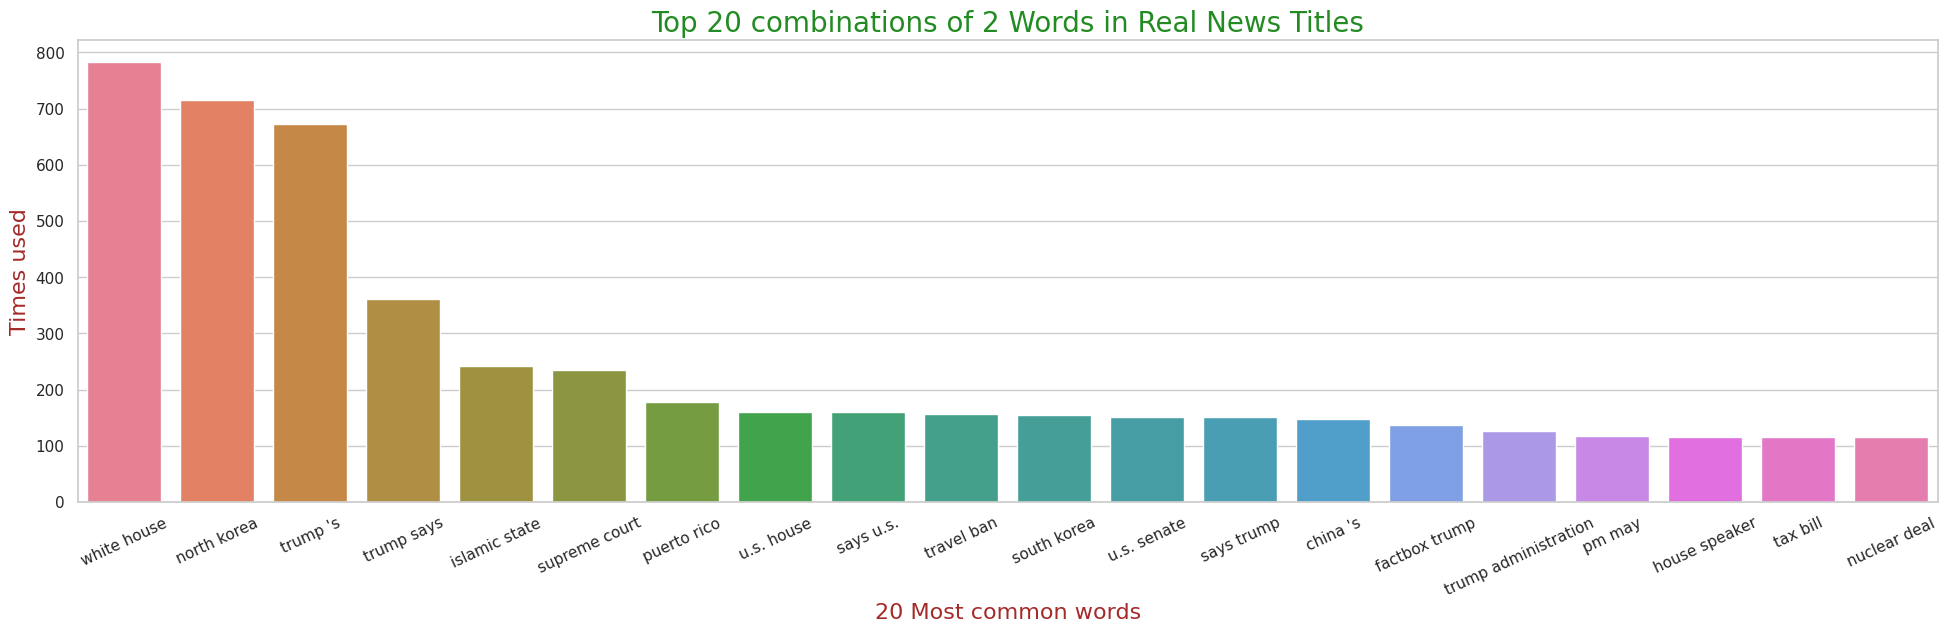

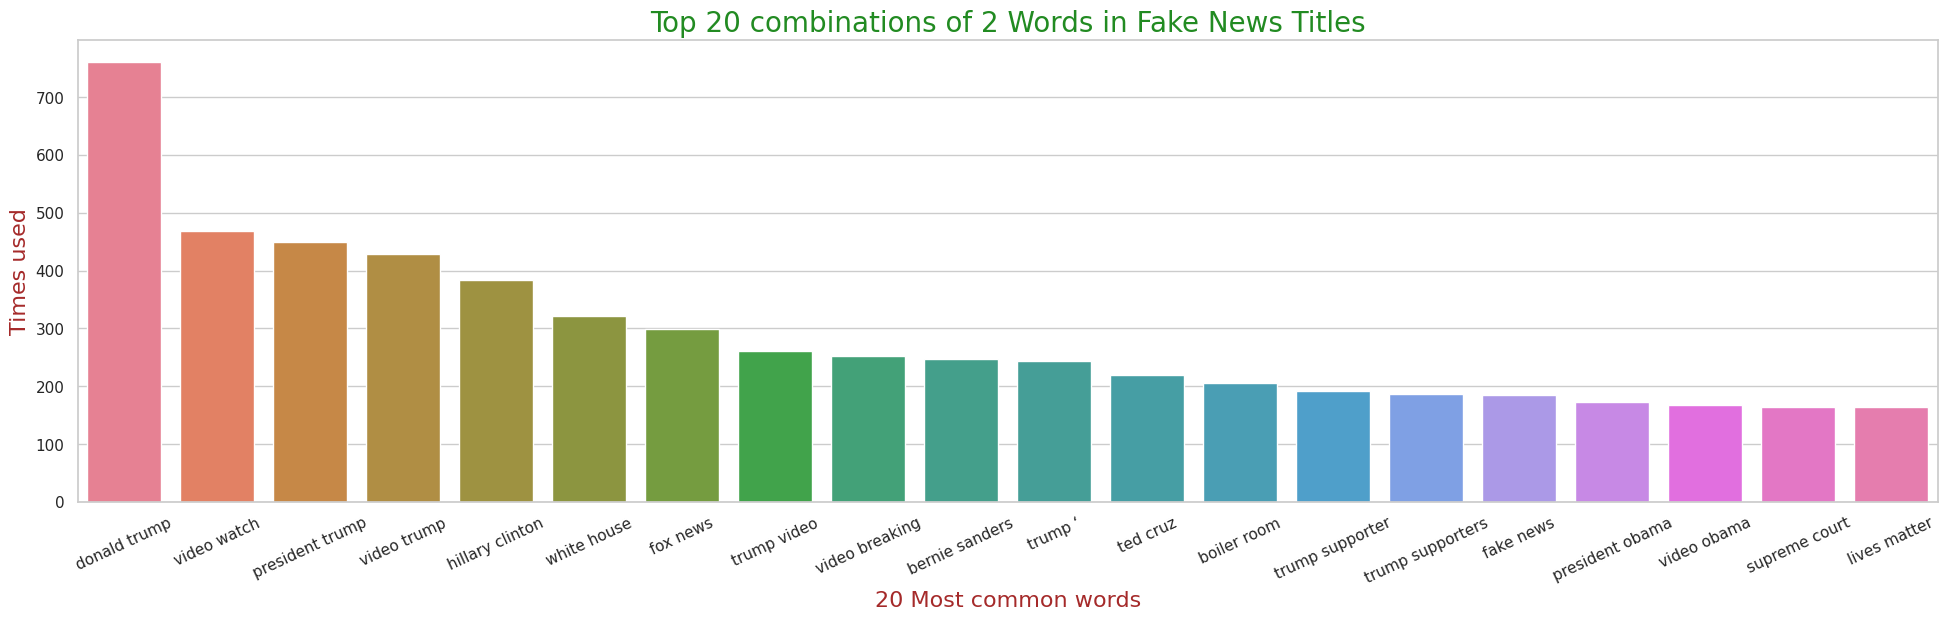

In [89]:
plot_bar_chart_for_ngram_most_common_20(real_news_dataset2_title_bi_gram, "2 Words in Real News Titles")
plot_bar_chart_for_ngram_most_common_20(fake_news_dataset2_title_bi_gram, "2 Words in Fake News Titles")

Here, a different trend showed up. Real news mention foreign countries a lot more. Maybe fake news tend to cover more of the inner politics of the US, because that way they can influence public opinion on different political figures.

## **3. Feature Extraction**
In this section, we are going to combine the datasets into one, keeping only the columns, which both datasets have. After that, we are going to use various tools and methods to extract certain features from the text and try to find some feature, where real and fake news differ. Because this feature extraction requires computational power, time and memory, we will load every feature from this section from a file in `/saved_data`. The code, which was used to compute these features is commented and can be run if needed.

Let's combine the datasets. First we will generate labels for the articles in the second one.

In [ ]:
real_news_dataset2["label"] = 0
fake_news_dataset2["label"] = 1

In [91]:
all_news_dataset2 = pd.concat([real_news_dataset2, fake_news_dataset2])
all_news_dataset2

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
23476  21st Century Wire says As 21WIRE reported earl...   Middle-east   
23477  21st Century Wire says It s a familiar theme. ...   Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
23479  21st Century Wire says Al Jazeera America will...   Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  
0      December 31, 2017       0  
1      December 29, 2017       0  
2      December 31, 2017       0  
3      December 30, 2017       0  
4      December 29, 2017       0  
...                   ...    ...  
23476    January 16, 2016      1  
23477    January 16, 2016      1  
23478    January 15, 2016      1  
23479    January 14, 2016      1  
23480    January 12, 2016      1  

[44177 rows x 5 columns]

In [92]:
combined_dataset = pd.concat([labeled_news_dataset1[["title", "text", "label"]], all_news_dataset2[["title", "text", "label"]]])
combined_dataset = combined_dataset.reset_index()
combined_dataset

index                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
69339  23476  McPain: John McCain Furious That Iran Treated ...   
69340  23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
69341  23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
69342  23479  How to Blow $700 Million: Al Jazeera America F...   
69343  23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text  label  
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1      Ever get the feeling your life circles the rou...      0  
2      Why the Truth Might Get You Fired October 29, ...      1  
3      Videos 15 Civilians Killed In Single US Airstr...      1  
4      Print \nAn Iranian woman has been sentenced to...      1  
...                                                  ...    ...  
69339  21st Century Wire says As 21WIRE reported earl...      1  
69340  21st Century Wire says It s a familiar theme. ...      1  
69341  Patrick Henningsen  21st Century WireRemember ...      1  
69342  21st Century Wire says Al Jazeera America will...      1  
69343  21st Century Wire says As 21WIRE predicted in ...      1  

[69344 rows x 4 columns]

### **POS-Tagging**
Now we will do some feature engineering, starting with POS-tagging. This is the process of marking up words in a text, corresponding to a particular part of speech, such as nouns, verbs, adjectives, etc., based on both their definition and context. The reason we do this is to find if there are different linguistic patterns between the different articles. For example, fake news might use more emotionally charged adjectives or adverbs, while real news might be more noun or fact-oriented. You can read more about it in [this article](https://www.geeksforgeeks.org/nlp-part-of-speech-default-tagging/) For this task we will use the `nltk` library.

In [93]:
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gecata/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [94]:
def count_pos_tags_nltk(text):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    pos_counts = {
        'nouns': 0,
        'verbs': 0,
        'adjectives': 0,
        'adverbs': 0,
        'pronouns': 0,
        'conjunctions': 0,
        'other': 0
    }

    for word, tag in pos_tags:
        if tag.startswith('NN'):
            pos_counts['nouns'] += 1
        elif tag.startswith('VB'):
            pos_counts['verbs'] += 1
        elif tag.startswith('JJ'):
            pos_counts['adjectives'] += 1
        elif tag.startswith('RB'):
            pos_counts['adverbs'] += 1
        elif tag.startswith('PRP'):
            pos_counts['pronouns'] += 1
        elif tag == 'CC' or tag == 'IN':
            pos_counts['conjunctions'] += 1
        else:
            pos_counts['other'] += 1


    return pos_counts

In [95]:
# combined_dataset["pos_counts"] = combined_dataset["text"].apply(count_pos_tags_nltk)

In [96]:
# combined_dataset["pos_counts"].to_json("saved_data/pos_counts.json", orient = "records")

In [97]:
# combined_dataset = combined_dataset.drop(columns = ["pos_counts"])

In [98]:
# pos_counts_df = pd.read_json("/pos_counts.json", orient="records")

In [99]:
# combined_dataset = combined_dataset.reset_index(drop=True)
# pos_counts_df = pos_counts_df.reset_index(drop=True)

In [100]:
# combined_dataset_with_new_features = pd.concat([combined_dataset, pos_counts_df], axis=1)
# combined_dataset_with_new_features

In [101]:
pos_tagging_dataset = pd.read_csv("saved_data/pos_tagging.csv")
pos_tagging_dataset

nouns  verbs  adjectives  adverbs  pronouns  conjunctions  other
0        281    147          72       40        54           128    221
1        238    108          53       38        60           123    202
2        420    203         108       67        67           202    387
3        194     99          41       15        19            91    153
4         58     35           7        3         5            18     51
...      ...    ...         ...      ...       ...           ...    ...
69339    184     78          51       24        11            85    120
69340     99     51          27       11        10            37     98
69341   1296    644         414      212       135           721   1169
69342    163     71          39       13        22            71    129
69343    312    162          69       32        14           130    262

[69344 rows x 7 columns]

In [102]:
combined_dataset_with_new_features = combined_dataset.copy()
combined_dataset_with_new_features.loc[:, ["nouns", "verbs", "adjectives", "adverbs", "pronouns", "conjunctions", "other"]] = pos_tagging_dataset[["nouns", "verbs", "adjectives", "adverbs", "pronouns", "conjunctions", "other"]]
combined_dataset_with_new_features

index                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
69339  23476  McPain: John McCain Furious That Iran Treated ...   
69340  23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
69341  23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
69342  23479  How to Blow $700 Million: Al Jazeera America F...   
69343  23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text  label  nouns  verbs  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1    281    147   
1      Ever get the feeling your life circles the rou...      0    238    108   
2      Why the Truth Might Get You Fired October 29, ...      1    420    203   
3      Videos 15 Civilians Killed In Single US Airstr...      1    194     99   
4      Print \nAn Iranian woman has been sentenced to...      1     58     35   
...                                                  ...    ...    ...    ...   
69339  21st Century Wire says As 21WIRE reported earl...      1    184     78   
69340  21st Century Wire says It s a familiar theme. ...      1     99     51   
69341  Patrick Henningsen  21st Century WireRemember ...      1   1296    644   
69342  21st Century Wire says Al Jazeera America will...      1    163     71   
69343  21st Century Wire says As 21WIRE predicted in ...      1    312    162   

       adjectives  adverbs  pronouns  conjunctions  other  
0              72       40        54           128    221  
1              53       38        60           123    202  
2             108       67        67           202    387  
3              41       15        19            91    153  
4               7        3         5            18     51  
...           ...      ...       ...           ...    ...  
69339          51       24        11            85    120  
69340          27       11        10            37     98  
69341         414      212       135           721   1169  
69342          39       13        22            71    129  
69343          69       32        14           130    262  

[69344 rows x 11 columns]

Now that we have the POS-tags loaded, let's create a bunch of bar plots to look for any patterns, involving the number of part-of-speech elements from each article.

In [103]:
def create_barplot_grid_for_pos_elements():
    pos_elements = ["nouns", "verbs", "adjectives", "adverbs", "pronouns", "conjunctions"]

    fig, axes = plt.subplots(6, 3, figsize=(15, 30))

    x_axis = ["Real News", "Fake News"]

    for i in range(0, 6):
        axes[i, 0] = sns.barplot(x = x_axis, y = [combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0][pos_elements[i]].sum(), combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1][pos_elements[i]].sum()], hue = x_axis, ax = axes[i, 0], saturation = 1)
        axes[i, 0].set_ylabel(f"Sum of all {pos_elements[i]}", color = "brown")

        axes[i, 1] = sns.barplot(x = x_axis, y = [combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0][pos_elements[i]].mean(), combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1][pos_elements[i]].mean()], hue = x_axis, ax = axes[i, 1], saturation = 1)
        axes[i, 1].set_ylabel(f"Mean of all {pos_elements[i]}", color = "brown")

        axes[i, 2] = sns.barplot(x = x_axis, y = [combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0][pos_elements[i]].median(), combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1][pos_elements[i]].median()], hue = x_axis, ax = axes[i, 2], saturation = 1)
        axes[i, 2].set_ylabel(f"Median of all {pos_elements[i]}", color = "brown")


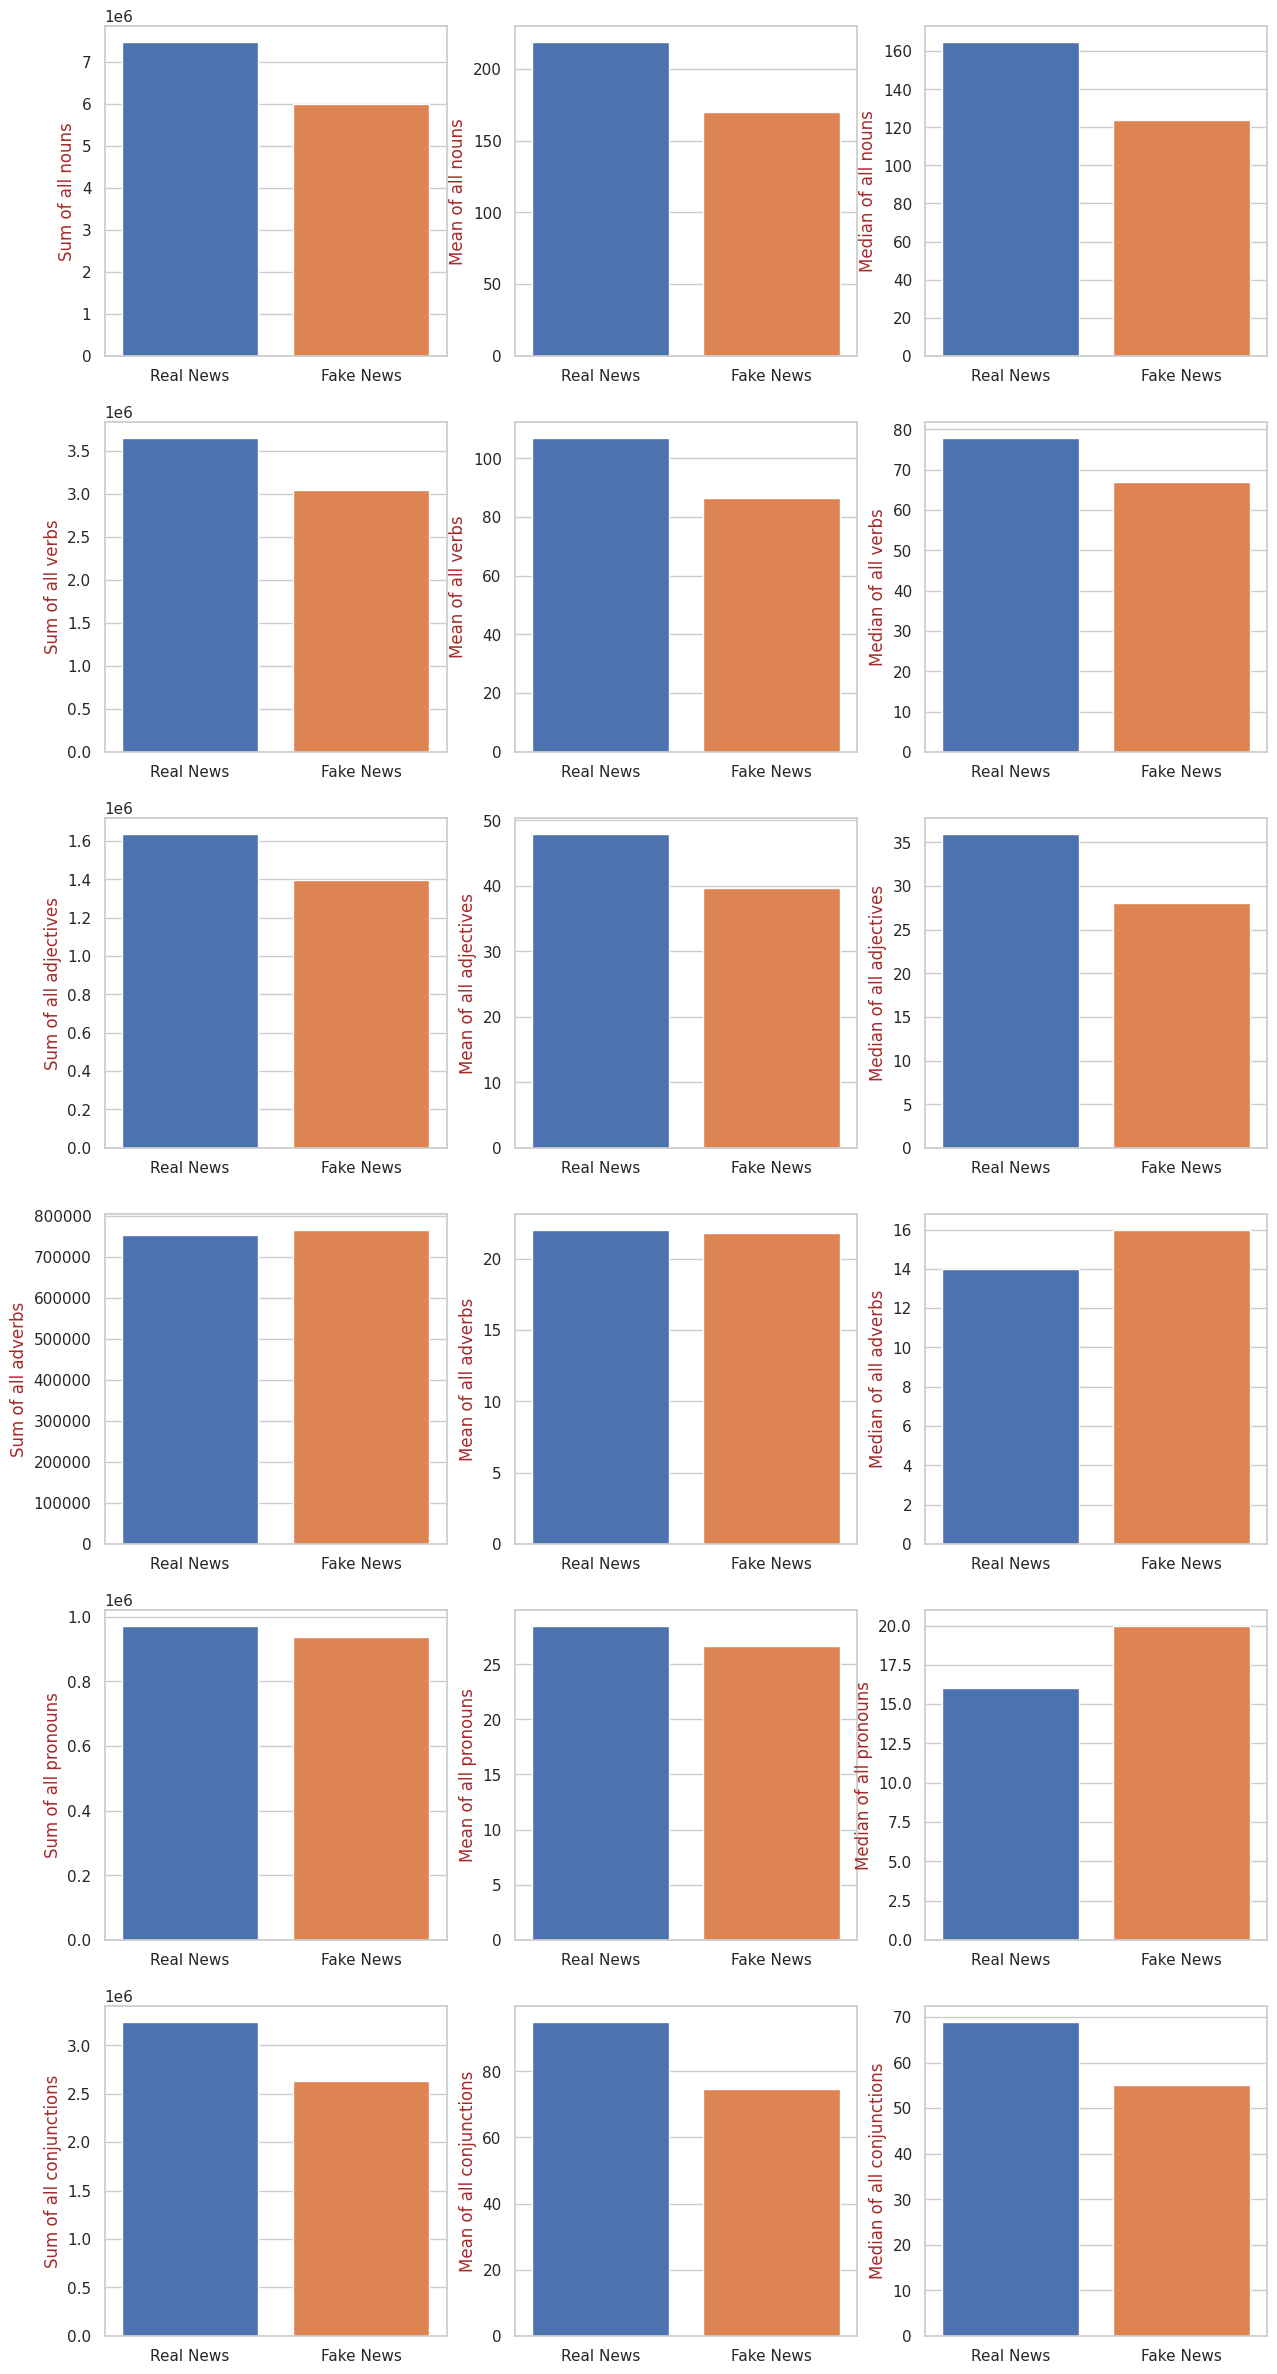

In [104]:
create_barplot_grid_for_pos_elements()

Sadly, we can't see an emerging pattern, using these metrics. The overall sums for everything are bigger due to the fact, that in the first dataset the real news articles are longer. Real news and fake news are basically indistinguishable, when it comes to their POS-tags.

### **Readability Scores**
The next step in the feature engineering is to measure the readability scores of each article. For this, we are going to use the Flesch Reading Ease formula. It gives every text a grade, ranging from 1 to 100, based on how readable it is. The higher the score, the more readable the text is. Here is roughly how it translates to education levels:
- **90-100**: Very easy to read (e.g., a 5th grader).
- **60-70**: Plain English (e.g., a 9th grader).
- **30-50**: Difficult to read (e.g., college level).
- **0-30**: Very difficult to read (e.g., legal documents).

It is calculated using this formula:
$$
\text{Flesch Reading Ease} = 206.835 - 1.015 \times \left(\frac{\text{Total Words}}{\text{Total Sentences}}\right) - 84.6 \times \left(\frac{\text{Total Syllables}}{\text{Total Words}}\right)
$$



You can read more about it [here](https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/).

In [105]:
combined_dataset_with_new_features

index                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
69339  23476  McPain: John McCain Furious That Iran Treated ...   
69340  23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
69341  23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
69342  23479  How to Blow $700 Million: Al Jazeera America F...   
69343  23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text  label  nouns  verbs  \
0      House Dem Aide: We Didn’t Even See Comey’s Let...      1    281    147   
1      Ever get the feeling your life circles the rou...      0    238    108   
2      Why the Truth Might Get You Fired October 29, ...      1    420    203   
3      Videos 15 Civilians Killed In Single US Airstr...      1    194     99   
4      Print \nAn Iranian woman has been sentenced to...      1     58     35   
...                                                  ...    ...    ...    ...   
69339  21st Century Wire says As 21WIRE reported earl...      1    184     78   
69340  21st Century Wire says It s a familiar theme. ...      1     99     51   
69341  Patrick Henningsen  21st Century WireRemember ...      1   1296    644   
69342  21st Century Wire says Al Jazeera America will...      1    163     71   
69343  21st Century Wire says As 21WIRE predicted in ...      1    312    162   

       adjectives  adverbs  pronouns  conjunctions  other  
0              72       40        54           128    221  
1              53       38        60           123    202  
2             108       67        67           202    387  
3              41       15        19            91    153  
4               7        3         5            18     51  
...           ...      ...       ...           ...    ...  
69339          51       24        11            85    120  
69340          27       11        10            37     98  
69341         414      212       135           721   1169  
69342          39       13        22            71    129  
69343          69       32        14           130    262  

[69344 rows x 11 columns]

In [106]:
# combined_dataset_with_new_features["reading_ease"] = combined_dataset_with_new_features["text"].apply(textstat.flesch_reading_ease)

In [107]:
# combined_dataset_with_new_features["reading_ease"].to_csv("saved_data/reading_ease.csv", index = False)

In [108]:
reading_ease_dataset = pd.read_csv("saved_data/reading_ease.csv")

In [109]:
combined_dataset_with_new_features["reading_ease"] = reading_ease_dataset

Let's take a look at the data we just loaded:

In [110]:
combined_dataset_with_new_features["reading_ease"].describe()

count    69344.000000
mean        56.944635
std         14.038849
min       -978.590000
25%         49.650000
50%         57.370000
75%         64.100000
max        206.840000
Name: reading_ease, dtype: float64

It's clear, that there are some outliars among the text contents. Let's explore them to see what we can do.

In [111]:
combined_dataset_with_new_features[reading_ease_dataset["reading_ease"] == 206.84][["reading_ease", "text"]]

reading_ease text
870          206.84     
58575        206.84     
58885        206.84     
62382        206.84     
65658        206.84

There are still 5 empty texts, which for some reason didn't get removed in the cleaning. We will remove them now.

In [112]:
combined_dataset_with_new_features = combined_dataset_with_new_features[combined_dataset_with_new_features["reading_ease"] != 206.84].reset_index()

In [113]:
def plot_readability():
    plt.figure(figsize = (12, 6))

    sns.histplot(data = combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0], x = "reading_ease", color = "blue", alpha = 0.7, label = "Real News")
    sns.histplot(data = combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1], x = "reading_ease", color = "orange", alpha = 0.7, label = "Fake News")

    plt.xlabel("Flesch Reading Ease Score", size = 16, color = "brown")
    plt.ylabel("Number of Articles", size = 16, color = "brown")
    plt.xlim((0, 100))

    plt.legend()

    plt.title("Distribution of Flesch Reading Ease Scores", size = 20)


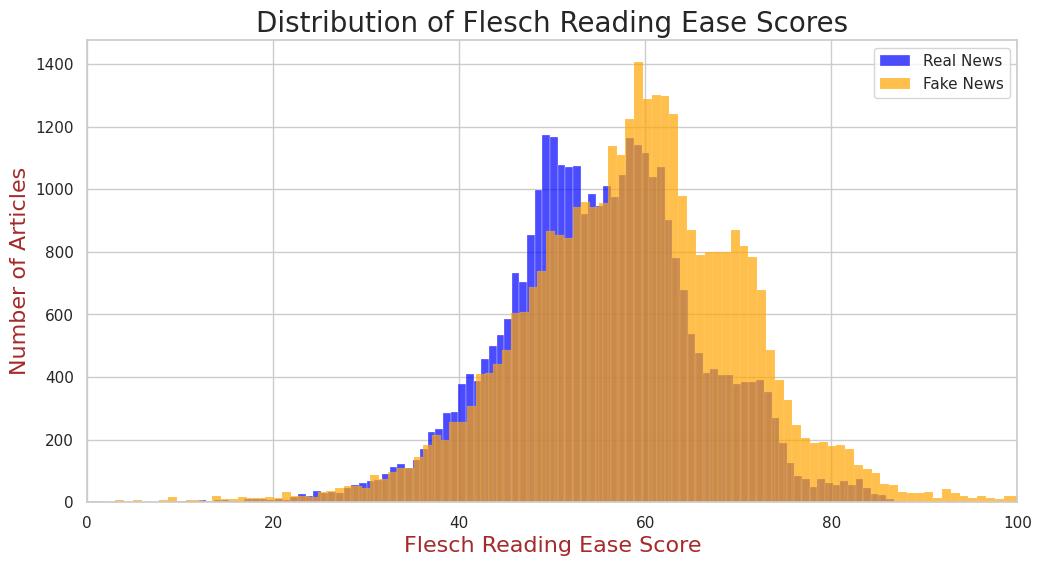

In [114]:
plot_readability()

As we can see from the histogram, again there is no apparent trend, where fake news are easier or harder to read, compared to real ones.

### **Lexical Diversity**
Now let's try calculating the lexical diversity for each article. Lexical diversity is a measure of the variety of words used in a text. It gives insight into how rich and varied the vocabulary is. Lexical diversity is an important feature, because it can reveal information about the complexity, creativity, or repetitiveness of a text.

In [115]:
def calculate_lexical_diversity(text):
    words = word_tokenize(text.lower())
    words = [word.lower() for word in words]
    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return len(set(words)) / len(words) if words else 0

In [116]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/gecata/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [117]:
# combined_dataset_with_new_features["lexical_diversity"] = combined_dataset_with_new_features["text"].apply(calculate_lexical_diversity)

In [118]:
# combined_dataset_with_new_features["lexical_diversity"].to_csv("saved_data/lexical_diversity.csv", index = False)

In [119]:
lexical_diversity_dataset = pd.read_csv("saved_data/lexical_diversity.csv")
combined_dataset_with_new_features["lexical_diversity"] = lexical_diversity_dataset

Let's take a look at the descriptive statistics for the lexical diversity for the real and the fake news.

In [120]:
combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0]["lexical_diversity"].describe()

count    34137.000000
mean         0.605477
std          0.108816
min          0.150752
25%          0.528651
50%          0.593023
75%          0.663551
max          1.000000
Name: lexical_diversity, dtype: float64

In [121]:
combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1]["lexical_diversity"].describe()

count    35202.000000
mean         0.648869
std          0.113629
min          0.138610
25%          0.578610
50%          0.638889
75%          0.701881
max          1.000000
Name: lexical_diversity, dtype: float64

It looks similar, but let's draw a histogram to be sure.

In [122]:
def plot_lexical_diversity():
    plt.figure(figsize = (12, 6))

    sns.histplot(data = combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0], x = "lexical_diversity", color = "blue", alpha = 0.7, label = "Real News")
    sns.histplot(data = combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1], x = "lexical_diversity", color = "orange", alpha = 0.7, label = "Fake News")

    plt.xlabel("Lexical Diversity", size = 16, color = "brown")
    plt.ylabel("Number of Articles", size = 16, color = "brown")
    plt.xlim((0, 1))

    plt.legend()

    plt.title("Distribution of Lexical Diversity", size = 20)

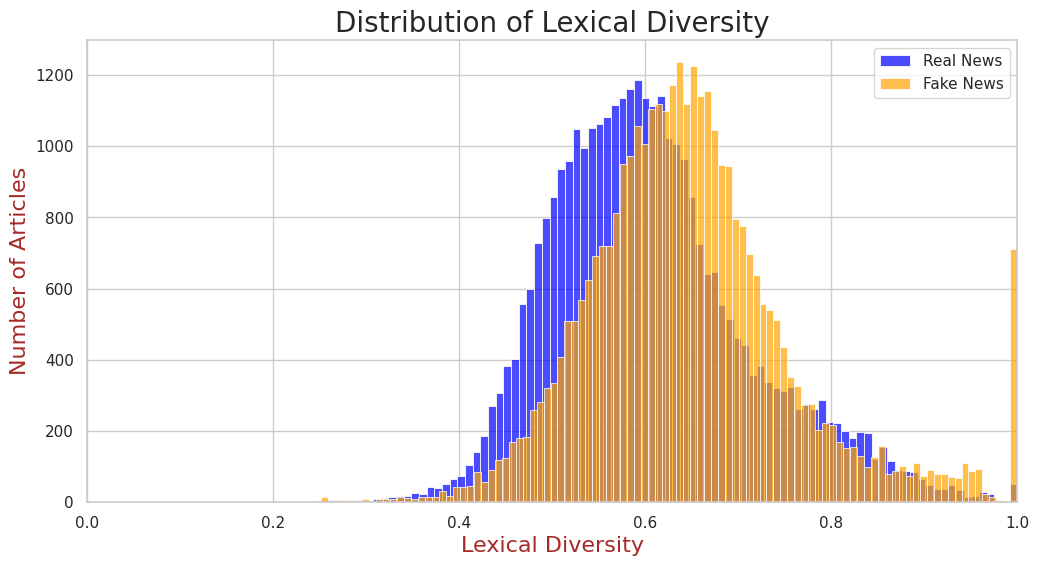

In [123]:
plot_lexical_diversity()

Again, real and fake news have very similar lexical diversity. Another feature, with which we can't be sure if an article is real or fake.

### **Sentiment Analysis**
Now it's time to perform sentiment analysis. Sentiment analysis is the process of determining the attitude expressed in a piece of text. This can be positive, negative, or neutral. In natural language processing, sentiment analysis is commonly used to gauge public opinion, monitor brand reputation, and understand customer feedback. For this we are going to use a more advanced deep learning model, called DistilBERT. DistilBERT is a distilled version of the BERT (Bidirectional Encoder Representations from Transformers) model. It is designed to be lighter, faster, and more efficient than the original BERT model while maintaining a high level of accuracy. DistilBERT is particularly well-suited for sentiment analysis due to its ability to capture nuanced language patterns in text. [Here is the model page](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english)

In [124]:
# sentiment_dataset = Dataset.from_pandas(combined_dataset_with_new_features[["text"]])

In [125]:
# sentiment_analysis = pipeline(
#     "sentiment-analysis",
#     model = "distilbert-base-uncased-finetuned-sst-2-english",
#     device = 0 # Utilizing the GPU in Colab
# )

In [126]:
# def analyze_sentiment(batch):
#     results = sentiment_analysis(batch["text"], truncation = True)
#     return {"label": [result["label"] for result in results],
#             "score": [result["score"] for result in results]}

In [127]:
# results_sentiment = sentiment_dataset.map(analyze_sentiment, batched = True, batch_size = 2048)
# results_sentiment_df = results.to_pandas()

In [128]:
# results_sentiment_df

In [129]:
sentiments_dataframe = pd.read_csv("saved_data/sentiment.csv")
combined_dataset_with_new_features["sentiment"] = sentiments_dataframe["sentiment"]
combined_dataset_with_new_features["confidence"] = sentiments_dataframe["confidence"]

In [130]:
# combined_dataset_with_new_features["sentiment"] = results_sentiment_df["label"]
# combined_dataset_with_new_features["confidence"] = results_sentiment_df["score"]

In [131]:
# combined_dataset_with_new_features.to_csv("/content/drive/MyDrive/Data_science_final_project/saved_data/combined_dataset_with_new_features2.csv", index = False)


Let's take a look at the results. We'll start by looking at how confident the model was in its predictions.

In [132]:
combined_dataset_with_new_features["confidence"].describe()

count    69339.000000
mean         0.955103
std          0.093446
min          0.500074
25%          0.970890
50%          0.992459
75%          0.997119
max          0.999888
Name: confidence, dtype: float64

We can see, that it was very confident, which is very nice. Now let's plot two bar charts, comparing the sentiments on both ends.


In [133]:
def create_countplot_for_sentiment():
    plt.figure(figsize = (10, 6))
    ax = sns.countplot(
        data = combined_dataset_with_new_features,
        x = "sentiment",
        hue = "label",
    )

    ax.set_xlabel("Sentiment", fontsize = 14)
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_title("Distribution of Sentiment Emotion by Label", fontsize = 16)

    ax.legend(labels = ["Real News", "Fake News"])

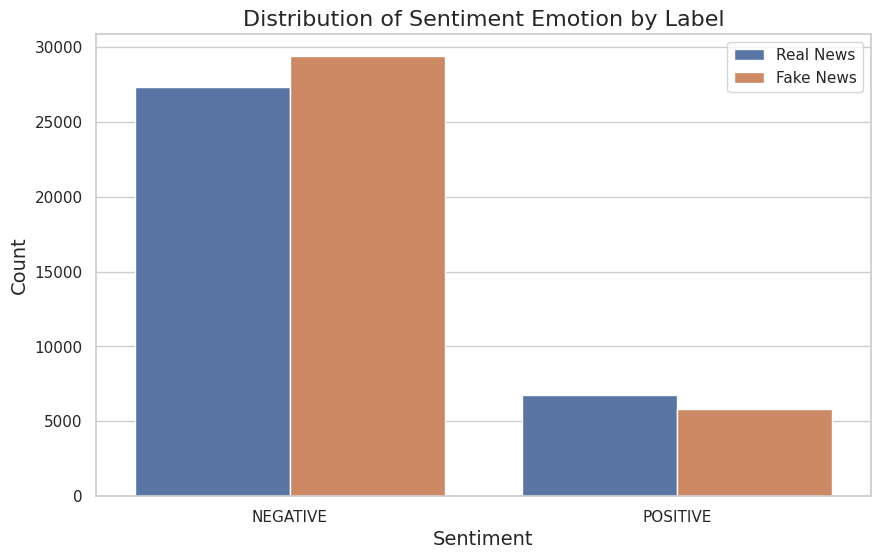

In [134]:
create_countplot_for_sentiment()

Again, similar results.

### **Emotional Analysis**
Lastly, we will perform emotional analysis. Emotional analysis is a more granular form of sentiment analysis. Instead of categorizing text as merely positive, negative, or neutral, emotional analysis aims to identify specific emotions like joy, sadness, anger, fear, surprise, etc. This approach provides deeper insights into the emotional tone of a text and can be particularly useful in contexts where understanding nuanced emotional states is important, such as customer feedback analysis, social media monitoring, or content analysis. For this task, we are going to use DistilRoBERTa. DistilRoBERTa is a distilled version of the RoBERTa (Robustly optimized BERT approach) model, designed to be lighter and faster while maintaining high accuracy. When fine-tuned for emotional analysis, DistilRoBERTa can identify a range of emotions in text with high precision. [Here is the model page](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/)


In [135]:
# emotion_dataset = Dataset.from_pandas(combined_dataset_with_new_features[["text"]])

In [136]:
# emotion_analysis = pipeline(
#     "text-classification",
#     model = "j-hartmann/emotion-english-distilroberta-base",
#     return_all_scores = True,
#     device = 0 # Utilizing the GPU in Colab
# )

In [137]:
def analyze_emotion(batch):
    results = emotion_analysis(batch["text"], truncation = True)

    top_emotions = []
    top_scores = []

    for result in results:
        top_result = max(result, key = lambda x: x["score"])
        top_emotions.append(top_result["label"])
        top_scores.append(top_result["score"])

    return {"top_emotion": top_emotions, "top_score": top_scores}

In [138]:
# results_emotion = emotion_dataset.map(analyze_emotion, batched = True, batch_size = 2048)
# results_emotion_df = results_emotion.to_pandas()

In [139]:
# results_emotion_df.to_csv("/content/drive/MyDrive/Data_science_final_project/saved_data/results_emotion.csv")


In [140]:
# results_emotion_df

In [141]:
emotions_dataframe = pd.read_csv("saved_data/emotion.csv")
combined_dataset_with_new_features.loc[:, "top_emotion"] = emotions_dataframe["top_emotion"]
combined_dataset_with_new_features.loc[:, "top_emotion_score"] = emotions_dataframe["top_emotion_score"]

In [142]:
# combined_dataset_with_new_features["top_emotion"] = results_emotion_df["top_emotion"]
# combined_dataset_with_new_features["top_emotion_score"] = results_emotion_df["top_score"]
# combined_dataset_with_new_features.to_csv("/content/drive/MyDrive/Data_science_final_project/saved_data/combined_dataset_with_new_features3.csv", index = False)


Let's take a look at the results, separating the real and the fake news:

In [143]:
combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 0]["top_emotion"].value_counts()

top_emotion
fear        12907
neutral      9554
anger        5795
sadness      2543
disgust      1523
joy          1358
surprise      457
Name: count, dtype: int64

In [144]:
combined_dataset_with_new_features[combined_dataset_with_new_features["label"] == 1]["top_emotion"].value_counts()

top_emotion
fear        12414
neutral      7820
anger        7511
disgust      2681
sadness      2002
surprise     1840
joy           934
Name: count, dtype: int64

Now let's create a countplot and observe our results:

In [145]:
def create_countplot_for_emotions():
    plt.figure(figsize = (10, 6))
    ax = sns.countplot(
        data = combined_dataset_with_new_features,
        x = "top_emotion",
        hue = "label",
    )

    ax.set_xlabel("Top Emotion", fontsize = 14)
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_title("Distribution of Top Emotions by Label", fontsize = 16)

    ax.legend(labels = ["Real News", "Fake News"])

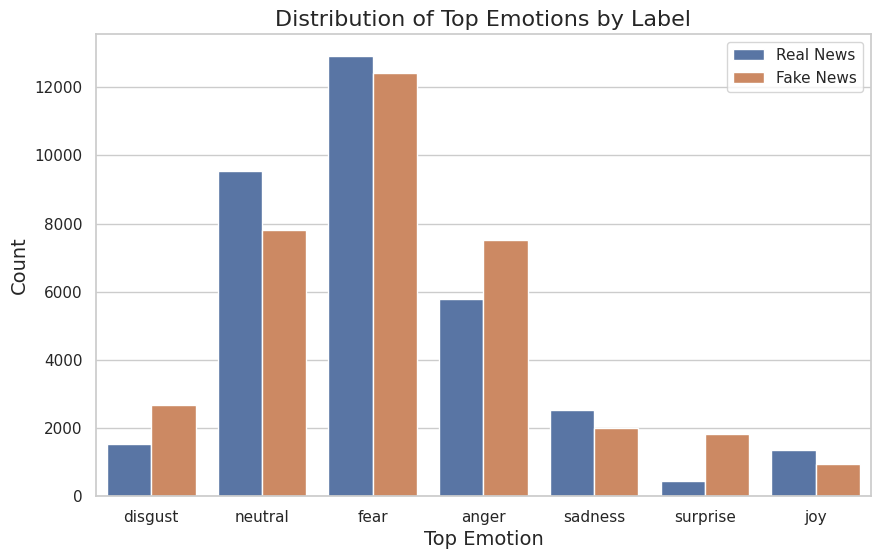

In [146]:
create_countplot_for_emotions()

In both the real and fake news, "fear" is the leading emotion, which isn't surprising at all, given the news we constantly hear. Even if "surprise" is not the most prevalent emotion overall, it appears a lot more in fake news. That can be said, although without that big of a difference, for "anger" and "disgust". Fake news use these strong emotions in order to be more believable.

## **4. Conclusion**
Having explored the differences between real and fake news, we can now address the key questions we set out at the beginning of this project:
1.   ***What linguistic features most distinguish real news from fake news?***
   
Our analysis reveals that fake news has become so adept at mimicking the linguistic patterns of real news that they are nearly indistinguishable when considering POS-tagging, reading ease, and lexical diversity alone.

2.   ***How do sentiment and emotional tone differ between real and fake news?***

The sentiment analysis shows that real and fake news articles have a similar balance of positive and negative tones, making sentiment an unreliable factor for differentiation. However, fake news tends to evoke emotions like "disgust," "anger," and especially "surprise" slightly more frequently.

3.   ***What is the most important thing to look for, in order to spot a fake article?***

Judging by everything we explored in this project, the most important thing to look for is the news source. We discovered, that usually, authors of real news stick to writing only real news and vice versa. We also discovered, that many of the real news come from a reputable source like "New York Times".

In summary, while fake news has evolved to closely resemble real news in both language and sentiment, the reliability of the source remains the strongest indicator of authenticity.

### **Future Work**
Future research could explore more advanced techniques, such as deep learning models trained specifically on distinguishing real from fake news. Additionally, investigating the role of metadata, such as publication date and social media engagement, could provide further insights into effective fake news detection.


## **5. References**
1. Kaggle. *Fake News Dataset*. Retrieved from [https://www.kaggle.com/c/fake-news/data](https://www.kaggle.com/c/fake-news/data)
2. University of Victoria. *ISOT Fake News Dataset*. Retrieved from [https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/](https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/)
3. Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text
classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley,
January/February 2018.
4. Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram
Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds)
Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments.
ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-
138).
5. GeeksforGeeks. *POS-Tagging Article: NLP - Part of Speech (POS) Tagging*. Retrieved from [https://www.geeksforgeeks.org/nlp-part-of-speech-default-tagging/](https://www.geeksforgeeks.org/nlp-part-of-speech-default-tagging/)
6. Readable. *Flesch Reading Ease and the Flesch-Kincaid Grade Level*. Retrieved from [https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/](https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/)
7. Hugging Face. *DistilBERT Documentation*. Retrieved from [https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english)
8. Jochen Hartmann, "Emotion English DistilRoBERTa-base". https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/, 2022.